In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from   sklearn.preprocessing     import StandardScaler
from   sklearn.preprocessing     import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
import pickle
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
def box_plot(df,ls):
    my_dict = dict(zip(ls,[df[x].tolist() for x in ls]))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    plt.xticks(rotation=45)

def count_plot(col,df,flag='CHURN'):
    print(col)
    ax = sns.countplot(x=col, data=df, hue=flag)
    if len(set(df[col].tolist()))>15:
        size = 6
    else:
        size = 12
    plt.xticks(rotation=90,fontsize=size)
def woe_value(vard,varc,df,columna_flag):
    ls_col                                              = []
    for v in vard:
        aux                                             = df[[v,columna_flag]].copy()
        aux['n']                                        = 1
        aux                                             = aux.pivot_table(index=v,columns=columna_flag,
                                                                          aggfunc='count')
        aux.columns                                     = aux.columns.droplevel()
        aux.reset_index(inplace=True)
        for i in range(2):
            aux[i]/= aux[i].sum()
        aux['woe']                                            = np.log(aux[0]/aux[1])
        aux['iv']                                             = aux['woe']*(aux[0]-aux[1])
        display(aux)
        woe                                                   = ((aux[0]-aux[1])*aux['woe']).sum()
        if woe>0.02 and woe<0.5:
            ls_col.append((v,woe))
        df                                                    = df.merge(aux[['woe',v]],how='inner',on=v)
        df.rename(columns={'woe':'W_%s'%v},inplace=True)
        print(v,aux['iv'].sum(),'-')
        #ls_iv.append((v,aux['iv'].sum(),'-'))
    for i,v in enumerate(varc):
        print(v)
        bestk                                           = 0
        best_iv                                         = 0
        for k in range(2,6):
            aux                                               = df[[v,columna_flag]].copy()
            aux[v]                                            = pd.cut(aux[v],bins=k,
                                                                       include_lowest=True).astype(str)
            aux['n']                                          = 1
            aux                                               = aux.pivot_table(index=v,columns=columna_flag,
                                                                                aggfunc='count')
            aux.columns                                       = aux.columns.droplevel()
            aux.reset_index(inplace=True)
            for i in range(2):
                aux[i]/= aux[i].sum()
            aux['woe']                                  = np.log(aux[0]/aux[1])
            aux['iv']                                   = aux['woe']*(aux[0]-aux[1])
            if (aux['iv'].sum()> best_iv) & (~np.isinf(aux['iv'].sum())):
                best_iv                                       = aux['iv'].sum()
                bestk                                         = k 
        display(aux)
        print(v,aux['iv'].sum(),'-')
        aux                                             = df[[v,columna_flag]].copy()
        
        #ls_iv.append((v,best_iv,bestk))
        aux[v]                                          = pd.cut(aux[v],bins=bestk,
                                                                 include_lowest=True).astype(str)
        aux['n']                                        = 1
        aux                                             = aux.pivot_table(index=v,columns=columna_flag,
                                                                          aggfunc='count')
        aux.columns                                     = aux.columns.droplevel()
        aux.reset_index(inplace=True)
        for i in range(2):
            aux[i]/= aux[i].sum()
        aux['woe']                                      = np.log(aux[0]/aux[1])
        df[v]                                           = pd.cut(df[v],bins=bestk,
                                                                 include_lowest=True).astype(str)
        woe                                                   = ((aux[0]-aux[1])*aux['woe']).sum()
        if woe>0.02 and woe<0.5:
            ls_col.append((v,woe))
        df                                              = df.merge(aux[['woe',v]],how='inner',on=v)
        df.rename(columns={'woe':'W_%s'%v},inplace=True)
    return df,ls_col

In [3]:
df_gn               = pd.read_csv('dataset_gn.csv')

df_gn.rename(columns={'account length':'ACCT_LENGTH','international plan':'FLAG_INTL_PLAN',
                      'voice mail plan':'FLAG_VOICEMAIL_PLAN','number vmail messages':'NUM_EMAILMESSG',
                      'customer service calls':'NUM_CUSTSERV_CALLS'},inplace=True)

df_gn.rename(columns=dict(zip(df_gn.columns,[x.replace(' ','_').upper() for x in df_gn.columns])),
            inplace=True)

In [4]:
df_gn_aux           = df_gn.copy()
df_gn['AREA_CODE']  = df_gn['AREA_CODE'].astype(str)
df_gn_exp1          = pd.DataFrame({'VARIABLE':df_gn.columns})
df_gn_exp1['#NULL'] = df_gn.isnull().sum().tolist()
df_gn_exp1['%NULL'] = df_gn_exp1['#NULL']/len(df_gn)
df_gn_exp1['TYPE']  = df_gn.dtypes.to_frame()[0].tolist()
ls_d                = df_gn.select_dtypes(include=['bool','object']).columns.tolist()
ls_d                = [x for x in ls_d if x not in ['CHURN','PHONE_NUMBER']]
ls_c                = list(set(df_gn.columns).difference(set(ls_d)))
ls_c                = [x for x in ls_c if x not in ['CHURN','PHONE_NUMBER']]
v_o                 = 'CHURN'
aidi                = 'PHONE_NUMBER'
df_gn_exp1['MIN']   = [df_gn[[x]].describe().loc['min'].tolist()[0] if x in ls_c else None for x in df_gn_exp1.VARIABLE]
df_gn_exp1['MAX']   = [df_gn[[x]].describe().loc['max'].tolist()[0] if x in ls_c else None for x in df_gn_exp1.VARIABLE]
df_gn_exp1['MEAN']  = [df_gn[[x]].describe().loc['mean'].tolist()[0] if x in ls_c else None for x in df_gn_exp1.VARIABLE]
df_gn_exp1['DESV']  = [df_gn[[x]].describe().loc['std'].tolist()[0] if x in ls_c else None for x in df_gn_exp1.VARIABLE]

,VARIABLE,#NULL,%NULL,TYPE,MIN,MAX,MEAN,DESV
0,STATE,0,0.0,object,-,-,-,-
1,ACCT_LENGTH,0,0.0,int64,1,243,101.065,39.8221
2,AREA_CODE,0,0.0,object,-,-,-,-
3,PHONE_NUMBER,0,0.0,object,-,-,-,-
4,FLAG_INTL_PLAN,0,0.0,object,-,-,-,-
5,FLAG_VOICEMAIL_PLAN,0,0.0,object,-,-,-,-
6,NUM_EMAILMESSG,0,0.0,int64,0,51,8.09901,13.6884
7,TOTAL_DAY_MINUTES,0,0.0,float64,0,350.8,179.775,54.4674
8,TOTAL_DAY_CALLS,0,0.0,int64,0,165,100.436,20.0691
9,TOTAL_DAY_CHARGE,0,0.0,float64,0,59.64,30.5623,9.25943


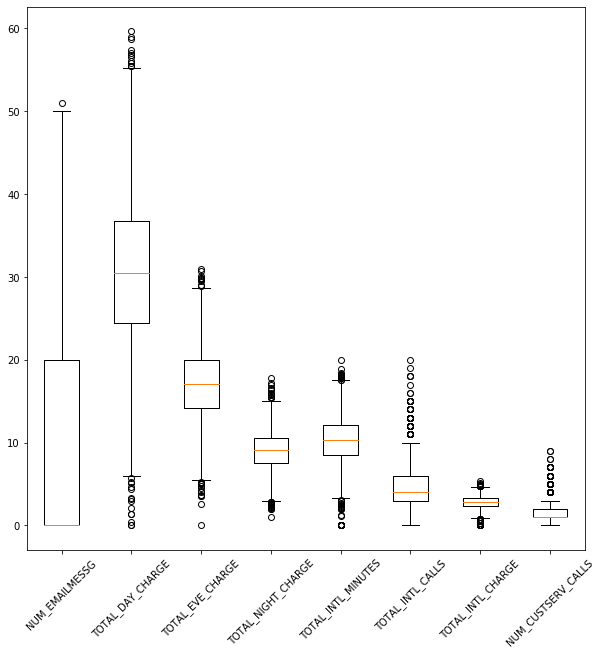

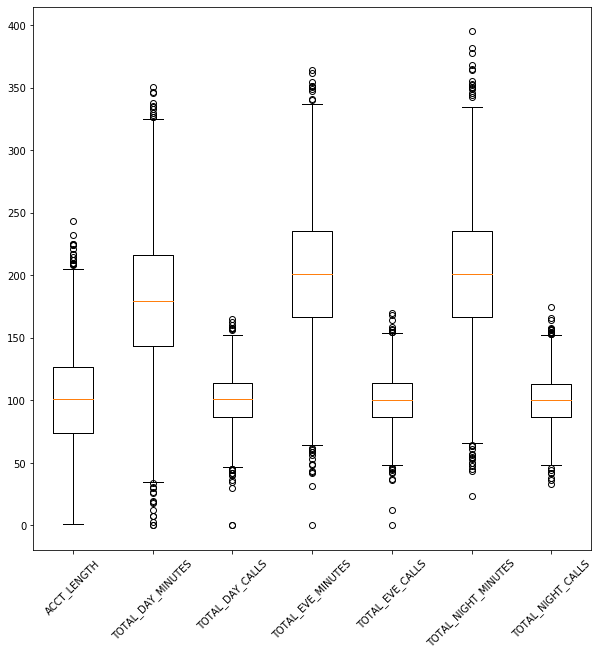

In [5]:
display(df_gn_exp1.fillna('-'))
ls_c_100 = df_gn_exp1[df_gn_exp1['MAX']<=100].VARIABLE.tolist()
box_plot(df_gn,ls_c_100)

ls_c_101 = df_gn_exp1[df_gn_exp1['MAX']>100].VARIABLE.tolist()
box_plot(df_gn,ls_c_101)

STATE


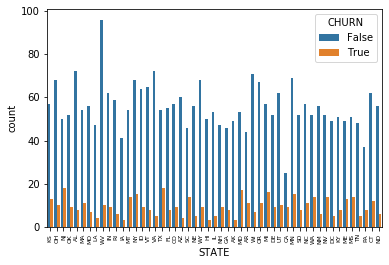

In [6]:
count_plot('STATE',df_gn)

FLAG_INTL_PLAN


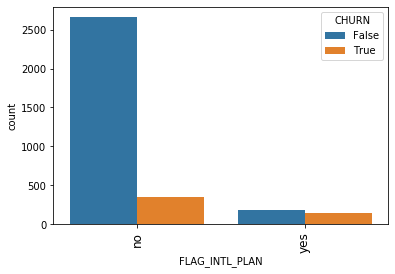

In [7]:
count_plot('FLAG_INTL_PLAN',df_gn)

FLAG_VOICEMAIL_PLAN


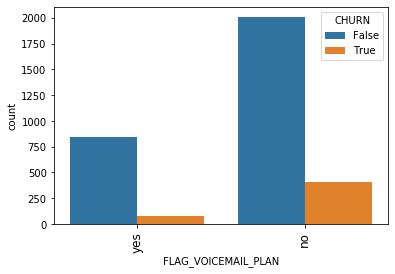

In [8]:
count_plot('FLAG_VOICEMAIL_PLAN',df_gn)

AREA_CODE


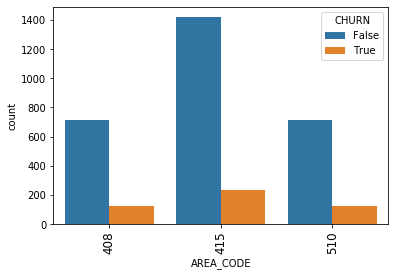

In [9]:
count_plot('AREA_CODE',df_gn)

In [10]:
df_gn.shape

(3333, 21)

In [11]:
for col in ls_c:
    for col_y in [col_y for col_y in ls_c if col_y!=col]:
        name = col_y+'/'+col
        df_gn[name] = df_gn[col_y]/df_gn[col]

In [12]:
df_gn.shape

(3333, 231)

In [13]:
231-21

210

In [14]:
#Checar nuevos outliers & nulos
df_nulls          = df_gn.isnull().sum().to_frame()
df_nulls['%NULL'] = df_nulls[0]/len(df_gn)
display(df_nulls[df_nulls['%NULL']>0.05])

,0,%NULL
NUM_CUSTSERV_CALLS/NUM_EMAILMESSG,504,0.151215
NUM_EMAILMESSG/NUM_CUSTSERV_CALLS,504,0.151215


In [15]:
#Borrar columnas con gran número de nulos
ls_drop_cols      = df_nulls[df_nulls['%NULL']>0.05].index.tolist()
df_gn             = df_gn[[x for x in df_gn if x not in ls_drop_cols]]


col_nulls         = df_gn.isnull().sum().to_frame()[df_gn.isnull().sum().to_frame()[0]>0].index.tolist()

#Ver un poco sobre los registros con nulos
display(df_gn[df_gn.isnull().any(axis=1)])
#Borrar registros con valores nulos
df_gn     = df_gn.dropna().reset_index(drop=True)
print(df_gn.shape)

,STATE,ACCT_LENGTH,AREA_CODE,PHONE_NUMBER,FLAG_INTL_PLAN,FLAG_VOICEMAIL_PLAN,NUM_EMAILMESSG,TOTAL_DAY_MINUTES,TOTAL_DAY_CALLS,TOTAL_DAY_CHARGE,TOTAL_EVE_MINUTES,TOTAL_EVE_CALLS,TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CALLS,TOTAL_NIGHT_CHARGE,TOTAL_INTL_MINUTES,TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE,NUM_CUSTSERV_CALLS,CHURN,TOTAL_DAY_CALLS/TOTAL_EVE_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_EVE_CALLS,TOTAL_INTL_CHARGE/TOTAL_EVE_CALLS,TOTAL_EVE_MINUTES/TOTAL_EVE_CALLS,TOTAL_EVE_CHARGE/TOTAL_EVE_CALLS,TOTAL_NIGHT_CALLS/TOTAL_EVE_CALLS,TOTAL_DAY_CHARGE/TOTAL_EVE_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_EVE_CALLS,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,TOTAL_INTL_MINUTES/TOTAL_EVE_CALLS,NUM_EMAILMESSG/TOTAL_EVE_CALLS,ACCT_LENGTH/TOTAL_EVE_CALLS,NUM_CUSTSERV_CALLS/TOTAL_EVE_CALLS,TOTAL_DAY_MINUTES/TOTAL_EVE_CALLS,TOTAL_EVE_CALLS/TOTAL_DAY_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_DAY_CALLS,TOTAL_INTL_CHARGE/TOTAL_DAY_CALLS,TOTAL_EVE_MINUTES/TOTAL_DAY_CALLS,TOTAL_EVE_CHARGE/TOTAL_DAY_CALLS,TOTAL_NIGHT_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_DAY_CALLS,TOTAL_INTL_CALLS/TOTAL_DAY_CALLS,TOTAL_INTL_MINUTES/TOTAL_DAY_CALLS,NUM_EMAILMESSG/TOTAL_DAY_CALLS,ACCT_LENGTH/TOTAL_DAY_CALLS,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,TOTAL_EVE_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_DAY_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_INTL_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_EVE_MINUTES/TOTAL_NIGHT_MINUTES,TOTAL_EVE_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_DAY_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_INTL_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_INTL_MINUTES/TOTAL_NIGHT_MINUTES,NUM_EMAILMESSG/TOTAL_NIGHT_MINUTES,ACCT_LENGTH/TOTAL_NIGHT_MINUTES,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_DAY_MINUTES/TOTAL_NIGHT_MINUTES,TOTAL_EVE_CALLS/TOTAL_INTL_CHARGE,TOTAL_DAY_CALLS/TOTAL_INTL_CHARGE,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CHARGE,TOTAL_EVE_MINUTES/TOTAL_INTL_CHARGE,TOTAL_EVE_CHARGE/TOTAL_INTL_CHARGE,TOTAL_NIGHT_CALLS/TOTAL_INTL_CHARGE,TOTAL_DAY_CHARGE/TOTAL_INTL_CHARGE,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CHARGE,TOTAL_INTL_CALLS/TOTAL_INTL_CHARGE,TOTAL_INTL_MINUTES/TOTAL_INTL_CHARGE,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,ACCT_LENGTH/TOTAL_INTL_CHARGE,NUM_CUSTSERV_CALLS/TOTAL_INTL_CHARGE,TOTAL_DAY_MINUTES/TOTAL_INTL_CHARGE,TOTAL_EVE_CALLS/TOTAL_EVE_MINUTES,TOTAL_DAY_CALLS/TOTAL_EVE_MINUTES,TOTAL_NIGHT_MINUTES/TOTAL_EVE_MINUTES,TOTAL_INTL_CHARGE/TOTAL_EVE_MINUTES,TOTAL_EVE_CHARGE/TOTAL_EVE_MINUTES,TOTAL_NIGHT_CALLS/TOTAL_EVE_MINUTES,TOTAL_DAY_CHARGE/TOTAL_EVE_MINUTES,TOTAL_NIGHT_CHARGE/TOTAL_EVE_MINUTES,TOTAL_INTL_CALLS/TOTAL_EVE_MINUTES,TOTAL_INTL_MINUTES/TOTAL_EVE_MINUTES,NUM_EMAILMESSG/TOTAL_EVE_MINUTES,ACCT_LENGTH/TOTAL_EVE_MINUTES,NUM_CUSTSERV_CALLS/TOTAL_EVE_MINUTES,TOTAL_DAY_MINUTES/TOTAL_EVE_MINUTES,TOTAL_EVE_CALLS/TOTAL_EVE_CHARGE,TOTAL_DAY_CALLS/TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES/TOTAL_EVE_CHARGE,TOTAL_INTL_CHARGE/TOTAL_EVE_CHARGE,TOTAL_EVE_MINUTES/TOTAL_EVE_CHARGE,TOTAL_NIGHT_CALLS/TOTAL_EVE_CHARGE,TOTAL_DAY_CHARGE/TOTAL_EVE_CHARGE,TOTAL_NIGHT_CHARGE/TOTAL_EVE_CHARGE,TOTAL_INTL_CALLS/TOTAL_EVE_CHARGE,TOTAL_INTL_MINUTES/TOTAL_EVE_CHARGE,NUM_EMAILMESSG/TOTAL_EVE_CHARGE,ACCT_LENGTH/TOTAL_EVE_CHARGE,NUM_CUSTSERV_CALLS/TOTAL_EVE_CHARGE,TOTAL_DAY_MINUTES/TOTAL_EVE_CHARGE,TOTAL_EVE_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_CALLS/TOTAL_NIGHT_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_INTL_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_EVE_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,TOTAL_INTL_MINUTES/TOTAL_NIGHT_CALLS,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,ACCT_LENGTH/TOTAL_NIGHT_CALLS,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CALLS/TOTAL_DAY_CHARGE,TOTAL_DAY_CALLS/TOTAL_DAY_CHARGE,TOTAL_NIGHT_MINUTES/TOTAL_DAY_CHARGE,TOTAL_INTL_CHARGE/TOTAL_DAY_CHARGE,TOTAL_EVE_MINUTES/TOTAL_DAY_CHARGE,TOTAL_EVE_CHARGE/TOTAL_DAY_CHARGE,TOTAL_NIGHT_CALLS/TOTAL_DAY_CHARGE,TOTAL_NIGHT_CHAR

(3312, 229)


In [16]:
ls_c  = df_gn.select_dtypes(include=['float64','int64']).columns.tolist()
ls_c  = [col for col in ls_c if np.inf not in df_gn[col].tolist()]
df_gn = df_gn[['CHURN','PHONE_NUMBER']+ls_d+ls_c]

corr  = df_gn[ls_c].corr()

In [17]:
df_gn.to_csv('dataset_cluster.csv',sep='|')

In [18]:
#Standarizar datos continuos
sc                 = StandardScaler()
Xs                 = pd.DataFrame(sc.fit_transform(df_gn[ls_c]),columns=ls_c)

Xs[ls_d+['CHURN']] = df_gn[ls_d+['CHURN']]


df_woe,ls_c_w      = woe_value(ls_d,ls_c,Xs,'CHURN')
df_woe_aux         = df_woe.copy()

CHURN,STATE,False,True,woe,iv
0,AK,0.017314,0.006224,1.023120,0.011347
1,AL,0.025442,0.016598,0.427137,0.003778
2,AR,0.015548,0.022822,-0.383794,0.002792
3,AZ,0.021201,0.008299,0.937962,0.012102
4,CA,0.008127,0.018672,-0.831818,0.008772
5,CO,0.020141,0.018672,0.075739,0.000111
6,CT,0.021908,0.024896,-0.127860,0.000382
7,DC,0.017314,0.010373,0.512295,0.003556
8,DE,0.018375,0.018672,-0.016069,0.000005
9,FL,0.019081,0.016598,0.139455,0.000346


STATE 0.20741535332624017 -


CHURN,AREA_CODE,False,True,woe,iv
0,408,0.250883,0.253112,-0.008844,0.000020
1,415,0.498587,0.487552,0.022381,0.000247
2,510,0.250530,0.259336,-0.034546,0.000304


AREA_CODE 0.0005708879515883508 -


CHURN,FLAG_INTL_PLAN,False,True,woe,iv
0,no,0.934276,0.715768,0.266416,0.058214
1,yes,0.065724,0.284232,-1.464322,0.319966


FLAG_INTL_PLAN 0.37818007825940436 -


CHURN,FLAG_VOICEMAIL_PLAN,False,True,woe,iv
0,no,0.703887,0.834025,-0.169646,0.022077
1,yes,0.296113,0.165975,0.578904,0.075337


FLAG_VOICEMAIL_PLAN 0.09741466279051952 -
ACCT_LENGTH


CHURN,ACCT_LENGTH,False,True,woe,iv
0,"(-0.0816, 1.132]",0.399293,0.417012,-0.043420,0.000769
1,"(-1.295, -0.0816]",0.371378,0.360996,0.028354,0.000294
2,"(-2.516, -1.295]",0.100353,0.087137,0.141217,0.001866
3,"(1.132, 2.346]",0.119081,0.120332,-0.010448,0.000013
4,"(2.346, 3.559]",0.009894,0.014523,-0.383794,0.001777


ACCT_LENGTH 0.0047197061409215615 -
NUM_EMAILMESSG


CHURN,NUM_EMAILMESSG,False,True,woe,iv
0,"(-0.597, 0.152]",0.706007,0.834025,-0.166638,0.021333
1,"(0.152, 0.896]",0.033216,0.016598,0.693765,0.011529
2,"(0.896, 1.64]",0.132509,0.062241,0.755641,0.053097
3,"(1.64, 2.384]",0.109894,0.064315,0.535718,0.024417
4,"(2.384, 3.128]",0.018375,0.022822,-0.216739,0.000964


NUM_EMAILMESSG 0.11134028297836172 -
TOTAL_DAY_MINUTES


CHURN,TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.702, 0.583]",0.516608,0.280083,0.612198,0.144800
1,"(-1.986, -0.702]",0.215901,0.178423,0.190662,0.007146
2,"(-3.2769999999999997, -1.986]",0.026148,0.022822,0.136082,0.000453
3,"(0.583, 1.867]",0.230389,0.375519,-0.488540,0.070902
4,"(1.867, 3.151]",0.010954,0.143154,-2.570207,0.339780


TOTAL_DAY_MINUTES 0.5630801682972149 -
TOTAL_DAY_CALLS


CHURN,TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.825, 0.529]",0.517668,0.473029,0.090177,0.004025
1,"(-2.18, -0.825]",0.183392,0.174274,0.050999,0.000465
2,"(-3.5429999999999997, -2.18]",0.014134,0.018672,-0.278433,0.001264
3,"(0.529, 1.884]",0.252297,0.294606,-0.155032,0.006559
4,"(1.884, 3.239]",0.032509,0.039419,-0.192738,0.001332


TOTAL_DAY_CALLS 0.013645047203038224 -
TOTAL_DAY_CHARGE


CHURN,TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.702, 0.583]",0.516608,0.280083,0.612198,0.144800
1,"(-1.986, -0.702]",0.215901,0.178423,0.190662,0.007146
2,"(-3.278, -1.986]",0.026148,0.022822,0.136082,0.000453
3,"(0.583, 1.867]",0.230742,0.375519,-0.487008,0.070507
4,"(1.867, 3.151]",0.010601,0.143154,-2.602997,0.345035


TOTAL_DAY_CHARGE 0.5679402431814238 -
TOTAL_EVE_MINUTES


CHURN,TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-0.729, 0.585]",0.487633,0.483402,0.008712,0.000037
1,"(-2.043, -0.729]",0.224382,0.151452,0.393078,0.028667
2,"(-3.364, -2.043]",0.022615,0.012448,0.597036,0.006070
3,"(0.585, 1.899]",0.241343,0.298755,-0.213406,0.012252
4,"(1.899, 3.213]",0.024028,0.053942,-0.808677,0.024190


TOTAL_EVE_MINUTES 0.07121627852442684 -
TOTAL_EVE_CALLS


CHURN,TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-1.258, 0.334]",0.520848,0.500000,0.040850,8.516486e-04
1,"(-2.85, -1.258]",0.101413,0.114108,-0.117939,1.497170e-03
2,"(-4.4510000000000005, -2.85]",0.001767,NaN,NaN,NaN
3,"(0.334, 1.927]",0.349117,0.358921,-0.027697,2.715545e-04
4,"(1.927, 3.519]",0.026855,0.026971,-0.004304,4.985229e-07


TOTAL_EVE_CALLS 0.0026208711420682308 -
TOTAL_EVE_CHARGE


CHURN,TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-0.73, 0.584]",0.487986,0.481328,0.013738,0.000091
1,"(-2.043, -0.73]",0.223322,0.151452,0.388342,0.027910
2,"(-3.3649999999999998, -2.043]",0.022968,0.012448,0.612540,0.006444
3,"(0.584, 1.898]",0.241696,0.300830,-0.218864,0.012942
4,"(1.898, 3.212]",0.024028,0.053942,-0.808677,0.024190


TOTAL_EVE_CHARGE 0.07157798851729552 -
TOTAL_NIGHT_MINUTES


CHURN,TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-0.571, 0.898]",0.524382,0.537344,-0.024420,0.000317
1,"(-2.041, -0.571]",0.272438,0.246888,0.098477,0.002516
2,"(-3.518, -2.041]",0.021555,0.010373,0.731348,0.008177
3,"(0.898, 2.367]",0.171378,0.199170,-0.150287,0.004177
4,"(2.367, 3.837]",0.010247,0.006224,0.498596,0.002006


TOTAL_NIGHT_MINUTES 0.01719287064346004 -
TOTAL_NIGHT_CALLS


CHURN,TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.526, 0.924]",0.536042,0.491701,0.086342,0.003829
1,"(-1.977, -0.526]",0.267138,0.288382,-0.076520,0.001626
2,"(-3.436, -1.977]",0.023675,0.022822,0.036709,0.000031
3,"(0.924, 2.374]",0.163251,0.184647,-0.123159,0.002635
4,"(2.374, 3.825]",0.009894,0.012448,-0.229643,0.000587


TOTAL_NIGHT_CALLS 0.008707132189562448 -
TOTAL_NIGHT_CHARGE


CHURN,TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-0.573, 0.896]",0.523322,0.537344,-0.026443,0.000371
1,"(-2.043, -0.573]",0.272438,0.246888,0.098477,0.002516
2,"(-3.52, -2.043]",0.021555,0.010373,0.731348,0.008177
3,"(0.896, 2.365]",0.172438,0.199170,-0.144121,0.003853
4,"(2.365, 3.835]",0.010247,0.006224,0.498596,0.002006


TOTAL_NIGHT_CHARGE 0.016922975742794368 -
TOTAL_INTL_MINUTES


CHURN,TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-0.607, 0.796]",0.529682,0.514523,0.029037,0.000440
1,"(-2.009, -0.607]",0.248763,0.192946,0.254091,0.014183
2,"(-3.42, -2.009]",0.023322,0.018672,0.222342,0.001034
3,"(0.796, 2.199]",0.185512,0.248963,-0.294181,0.018666
4,"(2.199, 3.602]",0.012721,0.024896,-0.671476,0.008175


TOTAL_INTL_MINUTES 0.042497955967311415 -
TOTAL_INTL_CALLS


CHURN,TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.442, 0.121]",0.572085,0.653527,-0.133097,0.010840
1,"(0.121, 1.675]",0.355830,0.278008,0.246803,0.019207
2,"(1.675, 3.229]",0.061837,0.056017,0.098861,0.000575
3,"(3.229, 4.783]",0.008481,0.010373,-0.201472,0.000381
4,"(4.783, 6.337]",0.001767,0.002075,-0.160650,0.000049


TOTAL_INTL_CALLS 0.03105269827259875 -
TOTAL_INTL_CHARGE


CHURN,TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-0.605, 0.797]",0.529682,0.514523,0.029037,0.000440
1,"(-2.007, -0.605]",0.246290,0.192946,0.244098,0.013021
2,"(-3.417, -2.007]",0.025795,0.018672,0.323147,0.002302
3,"(0.797, 2.199]",0.185512,0.248963,-0.294181,0.018666
4,"(2.199, 3.601]",0.012721,0.024896,-0.671476,0.008175


TOTAL_INTL_CHARGE 0.04260438212866105 -
NUM_CUSTSERV_CALLS


CHURN,NUM_CUSTSERV_CALLS,False,True,woe,iv
0,"(-1.1949999999999998, 0.18]",0.583746,0.443983,0.273678,0.038250
1,"(0.18, 1.548]",0.371025,0.271784,0.311260,0.030890
2,"(1.548, 2.916]",0.040636,0.238589,-1.770088,0.350395
3,"(2.916, 4.283]",0.004240,0.039419,-2.229620,0.078435
4,"(4.283, 5.651]",0.000353,0.006224,-2.868700,0.016841


NUM_CUSTSERV_CALLS 0.514810649274133 -
TOTAL_DAY_CALLS/TOTAL_EVE_CALLS


CHURN,TOTAL_DAY_CALLS/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.374, 2.641]",0.985159,0.987552,-0.002426,0.000006
1,"(17.61, 22.599]",0.000353,NaN,NaN,NaN
2,"(2.641, 7.631]",0.014488,0.012448,0.151725,0.000309


TOTAL_DAY_CALLS/TOTAL_EVE_CALLS 0.0003152474990010693 -
TOTAL_NIGHT_MINUTES/TOTAL_EVE_CALLS


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.5069999999999997, 2.066]",0.971378,0.983402,-0.012303,0.000148
1,"(15.715, 20.264]",0.000353,NaN,NaN,NaN
2,"(2.066, 6.616]",0.027915,0.016598,0.519918,0.005884
3,"(6.616, 11.165]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_EVE_CALLS 0.006032205209828314 -
TOTAL_INTL_CHARGE/TOTAL_EVE_CALLS


CHURN,TOTAL_INTL_CHARGE/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.356, 2.96]",0.990813,0.997925,-0.007153,0.000051
1,"(18.827, 24.115]",0.000353,NaN,NaN,NaN
2,"(2.96, 8.249]",0.008834,0.002075,1.448788,0.009793


TOTAL_INTL_CHARGE/TOTAL_EVE_CALLS 0.00984357162058188 -
TOTAL_EVE_MINUTES/TOTAL_EVE_CALLS


CHURN,TOTAL_EVE_MINUTES/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.3819999999999997, 1.591]",0.942756,0.935685,0.007529,0.000053
1,"(1.591, 5.543]",0.056184,0.064315,-0.135171,0.001099
2,"(13.447, 17.399]",0.000353,NaN,NaN,NaN
3,"(5.543, 9.495]",0.000707,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_EVE_CALLS 0.0011523994282425336 -
TOTAL_EVE_CHARGE/TOTAL_EVE_CALLS


CHURN,TOTAL_EVE_CHARGE/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.3819999999999997, 1.59]",0.942756,0.93361,0.009749,0.000089
1,"(1.59, 5.542]",0.056184,0.06639,-0.166920,0.001704
2,"(13.446, 17.398]",0.000353,NaN,NaN,NaN
3,"(5.542, 9.494]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_EVE_CALLS 0.001792796669221975 -
TOTAL_NIGHT_CALLS/TOTAL_EVE_CALLS


CHURN,TOTAL_NIGHT_CALLS/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.275, 1.817]",0.953357,0.954357,-0.001048,0.000001
1,"(1.817, 5.889]",0.046290,0.045643,0.014067,0.000009
2,"(14.032, 18.103]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_EVE_CALLS 1.0143988695528005e-05 -
TOTAL_DAY_CHARGE/TOTAL_EVE_CALLS


CHURN,TOTAL_DAY_CHARGE/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.475, 1.934]",0.974205,0.921162,0.055986,0.002970
1,"(1.934, 6.32]",0.025442,0.078838,-1.131008,0.060392
2,"(15.092, 19.478]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_EVE_CALLS 0.06336151025811695 -
TOTAL_NIGHT_CHARGE/TOTAL_EVE_CALLS


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.508, 2.066]",0.971378,0.983402,-0.012303,0.000148
1,"(15.715, 20.264]",0.000353,NaN,NaN,NaN
2,"(2.066, 6.615]",0.027915,0.016598,0.519918,0.005884
3,"(6.615, 11.165]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_EVE_CALLS 0.006032205209828314 -
TOTAL_INTL_CALLS/TOTAL_EVE_CALLS


CHURN,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-1.4489999999999998, 0.295]",0.694700,0.761411,-0.091693,0.006117
1,"(0.295, 2.03]",0.265018,0.199170,0.285637,0.018809
2,"(2.03, 3.765]",0.032509,0.035270,-0.081513,0.000225
3,"(3.765, 5.499]",0.006007,0.002075,1.063125,0.004181
4,"(5.499, 7.234]",0.001767,0.002075,-0.160650,0.000049


TOTAL_INTL_CALLS/TOTAL_EVE_CALLS 0.029380599517091478 -
TOTAL_INTL_MINUTES/TOTAL_EVE_CALLS


CHURN,TOTAL_INTL_MINUTES/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.358, 2.96]",0.990813,0.997925,-0.007153,0.000051
1,"(18.833, 24.124]",0.000353,NaN,NaN,NaN
2,"(2.96, 8.251]",0.008834,0.002075,1.448788,0.009793


TOTAL_INTL_MINUTES/TOTAL_EVE_CALLS 0.00984357162058188 -
NUM_EMAILMESSG/TOTAL_EVE_CALLS


CHURN,NUM_EMAILMESSG/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-0.581, 0.451]",0.717314,0.838174,-0.155712,0.018819
1,"(0.451, 1.476]",0.147350,0.078838,0.625412,0.042848
2,"(1.476, 2.501]",0.110601,0.066390,0.510379,0.022564
3,"(2.501, 3.526]",0.021908,0.012448,0.565287,0.005348
4,"(3.526, 4.551]",0.002827,0.004149,-0.383794,0.000508


NUM_EMAILMESSG/TOTAL_EVE_CALLS 0.0900867018946969 -
ACCT_LENGTH/TOTAL_EVE_CALLS


CHURN,ACCT_LENGTH/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-0.445, 1.238]",0.560777,0.543568,0.031168,0.000536
1,"(-2.137, -0.445]",0.342049,0.346473,-0.012850,0.000057
2,"(1.238, 2.921]",0.087279,0.105809,-0.192525,0.003567
3,"(2.921, 4.604]",0.007067,0.004149,0.532497,0.001554
4,"(4.604, 6.286]",0.002827,NaN,NaN,NaN


ACCT_LENGTH/TOTAL_EVE_CALLS 0.005714400613030686 -
NUM_CUSTSERV_CALLS/TOTAL_EVE_CALLS


CHURN,NUM_CUSTSERV_CALLS/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-1.097, 2.215]",0.981979,0.892116,0.095973,0.008624
1,"(12.096, 15.39]",0.000353,NaN,NaN,NaN
2,"(2.215, 5.508]",0.016961,0.103734,-1.810910,0.157139
3,"(5.508, 8.802]",0.000707,0.004149,-1.770088,0.006094


NUM_CUSTSERV_CALLS/TOTAL_EVE_CALLS 0.1718568752623618 -
TOTAL_DAY_MINUTES/TOTAL_EVE_CALLS


CHURN,TOTAL_DAY_MINUTES/TOTAL_EVE_CALLS,False,True,woe,iv
0,"(-2.475, 1.935]",0.974205,0.921162,0.055986,0.002970
1,"(1.935, 6.321]",0.025442,0.078838,-1.131008,0.060392
2,"(15.094, 19.48]",0.000353,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_EVE_CALLS 0.06336151025811695 -
TOTAL_EVE_CALLS/TOTAL_DAY_CALLS


CHURN,TOTAL_EVE_CALLS/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.365, 2.138]",0.581625,0.547718,0.060066,0.002037
1,"(-2.881, -0.365]",0.389753,0.408714,-0.047503,0.000901
2,"(2.138, 4.64]",0.026855,0.039419,-0.383794,0.004822
3,"(4.64, 7.143]",0.001060,0.004149,-1.364623,0.004216
4,"(7.143, 9.646]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_DAY_CALLS 0.011975112313935474 -
TOTAL_NIGHT_MINUTES/TOTAL_DAY_CALLS


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.836, 0.927]",0.652650,0.665975,-0.020211,0.000269
1,"(-2.608, -0.836]",0.195053,0.176349,0.100809,0.001886
2,"(0.927, 2.689]",0.136396,0.136929,-0.003905,0.000002
3,"(2.689, 4.451]",0.013781,0.014523,-0.052436,0.000039
4,"(4.451, 6.214]",0.002120,0.006224,-1.076941,0.004420


TOTAL_NIGHT_MINUTES/TOTAL_DAY_CALLS 0.006615557054631538 -
TOTAL_INTL_CHARGE/TOTAL_DAY_CALLS


CHURN,TOTAL_INTL_CHARGE/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.685, 1.172]",0.640989,0.641079,-0.000140,1.247876e-08
1,"(-2.553, -0.685]",0.247350,0.213693,0.146263,4.922772e-03
2,"(1.172, 3.03]",0.104947,0.128631,-0.203490,4.819401e-03
3,"(3.03, 4.888]",0.006007,0.016598,-1.016316,1.076324e-02
4,"(4.888, 6.745]",0.000707,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_DAY_CALLS 0.020505422676470524 -
TOTAL_EVE_MINUTES/TOTAL_DAY_CALLS


CHURN,TOTAL_EVE_MINUTES/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.476, 1.515]",0.583746,0.639004,-0.090446,0.004998
1,"(-2.4779999999999998, -0.476]",0.345583,0.280083,0.210147,0.013765
2,"(1.515, 3.507]",0.065018,0.068465,-0.051660,0.000178
3,"(3.507, 5.498]",0.004240,0.012448,-1.076941,0.008839
4,"(5.498, 7.489]",0.001413,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_DAY_CALLS 0.02777998222177268 -
TOTAL_EVE_CHARGE/TOTAL_DAY_CALLS


CHURN,TOTAL_EVE_CHARGE/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.477, 1.515]",0.583392,0.639004,-0.091051,0.005064
1,"(-2.479, -0.477]",0.345583,0.280083,0.210147,0.013765
2,"(1.515, 3.506]",0.065371,0.068465,-0.046240,0.000143
3,"(3.506, 5.497]",0.004240,0.012448,-1.076941,0.008839
4,"(5.497, 7.488]",0.001413,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_DAY_CALLS 0.02781059302270808 -
TOTAL_NIGHT_CALLS/TOTAL_DAY_CALLS


CHURN,TOTAL_NIGHT_CALLS/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.412, 1.617]",0.566078,0.531120,0.063743,0.002228
1,"(-2.452, -0.412]",0.373498,0.396266,-0.059171,0.001347
2,"(1.617, 3.646]",0.054770,0.068465,-0.223170,0.003056
3,"(3.646, 5.675]",0.004240,0.004149,0.021672,0.000002
4,"(5.675, 7.705]",0.001413,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_DAY_CALLS 0.006633612406991173 -
TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS


CHURN,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.562, 1.409]",0.626502,0.589212,0.061366,0.002288
1,"(-2.544, -0.562]",0.308127,0.242739,0.238528,0.015597
2,"(1.409, 3.379]",0.061484,0.141079,-0.830540,0.066107
3,"(3.379, 5.35]",0.003534,0.018672,-1.664727,0.025202
4,"(5.35, 7.321]",0.000353,0.008299,-3.156382,0.025079


TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS 0.13427238890649454 -
TOTAL_NIGHT_CHARGE/TOTAL_DAY_CALLS


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.836, 0.927]",0.652297,0.665975,-0.020753,2.838597e-04
1,"(-2.609, -0.836]",0.195053,0.176349,0.100809,1.885576e-03
2,"(0.927, 2.69]",0.136749,0.136929,-0.001318,2.376799e-07
3,"(2.69, 4.453]",0.013781,0.014523,-0.052436,3.890270e-05
4,"(4.453, 6.216]",0.002120,0.006224,-1.076941,4.419684e-03


TOTAL_NIGHT_CHARGE/TOTAL_DAY_CALLS 0.006628259884446002 -
TOTAL_INTL_CALLS/TOTAL_DAY_CALLS


CHURN,TOTAL_INTL_CALLS/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-1.4329999999999998, 0.476]",0.753357,0.790456,-0.048071,0.001783
1,"(0.476, 2.375]",0.214488,0.178423,0.184094,0.006639
2,"(2.375, 4.274]",0.026855,0.024896,0.075739,0.000148
3,"(4.274, 6.172]",0.004594,0.006224,-0.303751,0.000495
4,"(6.172, 8.071]",0.000707,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_DAY_CALLS 0.009066259542851734 -
TOTAL_INTL_MINUTES/TOTAL_DAY_CALLS


CHURN,TOTAL_INTL_MINUTES/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.69, 1.166]",0.642756,0.639004,0.005855,0.000022
1,"(-2.556, -0.69]",0.244876,0.213693,0.136213,0.004248
2,"(1.166, 3.021]",0.105654,0.130705,-0.212779,0.005330
3,"(3.021, 4.877]",0.006007,0.016598,-1.016316,0.010763
4,"(4.877, 6.733]",0.000707,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_DAY_CALLS 0.02036326284683096 -
NUM_EMAILMESSG/TOTAL_DAY_CALLS


CHURN,NUM_EMAILMESSG/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.579, 0.742]",0.743463,0.852697,-0.137086,0.014974
1,"(0.742, 2.057]",0.200707,0.112033,0.583049,0.051701
2,"(2.057, 3.371]",0.051237,0.033195,0.434057,0.007831
3,"(3.371, 4.685]",0.003887,0.002075,0.627807,0.001138
4,"(4.685, 6.0]",0.000707,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_DAY_CALLS 0.07564435377555345 -
ACCT_LENGTH/TOTAL_DAY_CALLS


CHURN,ACCT_LENGTH/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.0173, 2.114]",0.440989,0.429461,0.026491,0.000305
1,"(-2.1599999999999997, -0.0173]",0.531095,0.526971,0.007796,0.000032
2,"(2.114, 4.244]",0.025795,0.039419,-0.424067,0.005778
3,"(4.244, 6.375]",0.001767,0.004149,-0.853797,0.002034
4,"(6.375, 8.506]",0.000353,NaN,NaN,NaN


ACCT_LENGTH/TOTAL_DAY_CALLS 0.008149323928952745 -
NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS


CHURN,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-1.1269999999999998, 0.595]",0.795053,0.601660,0.278717,0.053902
1,"(0.595, 2.308]",0.187986,0.290456,-0.435087,0.044584
2,"(2.308, 4.021]",0.015194,0.089212,-1.770088,0.131017
3,"(4.021, 5.734]",0.001060,0.016598,-2.750917,0.042742
4,"(5.734, 7.447]",0.000707,0.002075,-1.076941,0.001473


NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS 0.2737180326356028 -
TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS


CHURN,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,False,True,woe,iv
0,"(-0.562, 1.409]",0.626502,0.589212,0.061366,0.002288
1,"(-2.544, -0.562]",0.308127,0.242739,0.238528,0.015597
2,"(1.409, 3.379]",0.061484,0.141079,-0.830540,0.066107
3,"(3.379, 5.35]",0.003534,0.018672,-1.664727,0.025202
4,"(5.35, 7.321]",0.000353,0.008299,-3.156382,0.025079


TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS 0.13427238890649454 -
TOTAL_EVE_CALLS/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_EVE_CALLS/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.116, 2.922]",0.985512,0.989627,-0.004166,0.000017
1,"(17.958, 22.971]",0.000353,NaN,NaN,NaN
2,"(2.922, 7.934]",0.013781,0.008299,0.507179,0.002780
3,"(7.934, 12.946]",0.000353,0.002075,-1.770088,0.003047


TOTAL_EVE_CALLS/TOTAL_NIGHT_MINUTES 0.005844488826970689 -
TOTAL_DAY_CALLS/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_DAY_CALLS/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-1.7619999999999998, 2.252]",0.973852,0.983402,-0.009760,9.321264e-05
1,"(14.234, 18.227]",0.000353,NaN,NaN,NaN
2,"(2.252, 6.246]",0.023675,0.014523,0.488695,4.472577e-03
3,"(6.246, 10.24]",0.002120,0.002075,0.021672,9.850291e-07


TOTAL_DAY_CALLS/TOTAL_NIGHT_MINUTES 0.004566774610269919 -
TOTAL_INTL_CHARGE/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_INTL_CHARGE/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.0189999999999997, 1.232]",0.916961,0.917012,-0.000056,2.871878e-09
1,"(1.232, 4.465]",0.078092,0.080913,-0.035487,1.001080e-04
2,"(10.931, 14.164]",0.000353,NaN,NaN,NaN
3,"(4.465, 7.698]",0.003887,0.002075,0.627807,1.137736e-03
4,"(7.698, 10.931]",0.000707,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_NIGHT_MINUTES 0.001237846640779674 -
TOTAL_EVE_MINUTES/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_EVE_MINUTES/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.0629999999999997, 0.952]",0.875265,0.875519,-0.000290,7.349922e-08
1,"(0.952, 3.951]",0.116608,0.120332,-0.031438,1.170815e-04
2,"(3.951, 6.95]",0.007067,0.004149,0.532497,1.553699e-03
3,"(6.95, 9.949]",0.000353,NaN,NaN,NaN
4,"(9.949, 12.948]",0.000707,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_NIGHT_MINUTES 0.001670854215085939 -
TOTAL_EVE_CHARGE/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_EVE_CHARGE/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.064, 0.952]",0.875265,0.875519,-0.000290,7.349922e-08
1,"(0.952, 3.951]",0.116608,0.120332,-0.031438,1.170815e-04
2,"(3.951, 6.95]",0.007067,0.004149,0.532497,1.553699e-03
3,"(6.95, 9.949]",0.000353,NaN,NaN,NaN
4,"(9.949, 12.948]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_NIGHT_MINUTES 0.001670854215085939 -
TOTAL_NIGHT_CALLS/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_NIGHT_CALLS/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-1.8339999999999999, 2.057]",0.965724,0.979253,-0.013912,0.000188
1,"(13.672, 17.543]",0.000353,NaN,NaN,NaN
2,"(2.057, 5.929]",0.031802,0.020747,0.427137,0.004722
3,"(5.929, 9.8]",0.001767,NaN,NaN,NaN
4,"(9.8, 13.672]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_NIGHT_MINUTES 0.004910302714479512 -
TOTAL_DAY_CHARGE/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_DAY_CHARGE/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.1149999999999998, 0.917]",0.874558,0.821577,0.062494,0.003311
1,"(0.917, 3.933]",0.119081,0.172199,-0.368846,0.019592
2,"(3.933, 6.948]",0.004947,0.006224,-0.229643,0.000293
3,"(6.948, 9.964]",0.001060,NaN,NaN,NaN
4,"(9.964, 12.98]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_NIGHT_MINUTES 0.02319657700300511 -
TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-0.158, 3.269]",0.545230,0.564315,-0.034406,0.000657
1,"(-10.459, -7.014]",0.000353,NaN,NaN,NaN
2,"(-3.586, -0.158]",0.452650,0.433610,0.042974,0.000818
3,"(-7.014, -3.586]",0.000707,0.002075,-1.076941,0.001473
4,"(3.269, 6.697]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_MINUTES 0.002948128916245351 -
TOTAL_INTL_CALLS/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_INTL_CALLS/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-1.2859999999999998, 1.873]",0.954417,0.968880,-0.015040,0.000218
1,"(1.873, 5.014]",0.042403,0.022822,0.619509,0.012131
2,"(11.297, 14.439]",0.000353,NaN,NaN,NaN
3,"(5.014, 8.156]",0.002473,0.006224,-0.922790,0.003461
4,"(8.156, 11.297]",0.000353,0.002075,-1.770088,0.003047


TOTAL_INTL_CALLS/TOTAL_NIGHT_MINUTES 0.018856164227166777 -
TOTAL_INTL_MINUTES/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_INTL_MINUTES/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.021, 1.224]",0.914841,0.917012,-0.002371,0.000005
1,"(1.224, 4.452]",0.080212,0.080913,-0.008700,0.000006
2,"(10.907, 14.135]",0.000353,NaN,NaN,NaN
3,"(4.452, 7.679]",0.003887,0.002075,0.627807,0.001138
4,"(7.679, 10.907]",0.000707,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_NIGHT_MINUTES 0.0011489808788321073 -
NUM_EMAILMESSG/TOTAL_NIGHT_MINUTES


CHURN,NUM_EMAILMESSG/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-0.564, 1.838]",0.934276,0.946058,-0.012532,0.000148
1,"(1.838, 4.227]",0.063604,0.051867,0.203993,0.002394
2,"(4.227, 6.615]",0.001767,0.002075,-0.160650,0.000049
3,"(9.004, 11.392]",0.000353,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_NIGHT_MINUTES 0.002591400237823011 -
ACCT_LENGTH/TOTAL_NIGHT_MINUTES


CHURN,ACCT_LENGTH/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-1.8239999999999998, 0.515]",0.769965,0.773859,-0.005045,0.000020
1,"(0.515, 2.841]",0.217314,0.219917,-0.011905,0.000031
2,"(2.841, 5.167]",0.009894,0.004149,0.868969,0.004992
3,"(5.167, 7.494]",0.001060,NaN,NaN,NaN
4,"(7.494, 9.82]",0.001767,0.002075,-0.160650,0.000049


ACCT_LENGTH/TOTAL_NIGHT_MINUTES 0.00509198873106316 -
NUM_CUSTSERV_CALLS/TOTAL_NIGHT_MINUTES


CHURN,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-1.0579999999999998, 2.154]",0.978092,0.885892,0.099008,0.009129
1,"(11.738, 14.932]",0.000353,NaN,NaN,NaN
2,"(2.154, 5.348]",0.021555,0.109959,-1.629506,0.144054
3,"(5.348, 8.543]",NaN,0.002075,NaN,NaN
4,"(8.543, 11.738]",NaN,0.002075,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_NIGHT_MINUTES 0.15318296440085552 -
TOTAL_DAY_MINUTES/TOTAL_NIGHT_MINUTES


CHURN,TOTAL_DAY_MINUTES/TOTAL_NIGHT_MINUTES,False,True,woe,iv
0,"(-2.1149999999999998, 0.917]",0.874558,0.821577,0.062494,0.003311
1,"(0.917, 3.932]",0.119081,0.172199,-0.368846,0.019592
2,"(3.932, 6.948]",0.004947,0.006224,-0.229643,0.000293
3,"(6.948, 9.963]",0.001060,NaN,NaN,NaN
4,"(9.963, 12.978]",0.000353,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_NIGHT_MINUTES 0.02319657700300511 -
TOTAL_EVE_CALLS/TOTAL_INTL_CHARGE


CHURN,TOTAL_EVE_CALLS/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-2.0269999999999997, 1.703]",0.961131,0.960581,0.000572,3.146280e-07
1,"(1.703, 5.414]",0.036042,0.037344,-0.035487,4.620368e-05
2,"(12.836, 16.546]",0.000707,NaN,NaN,NaN
3,"(5.414, 9.125]",0.001767,0.002075,-0.160650,4.946482e-05
4,"(9.125, 12.836]",0.000353,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_INTL_CHARGE 9.598313186780749e-05 -
TOTAL_DAY_CALLS/TOTAL_INTL_CHARGE


CHURN,TOTAL_DAY_CALLS/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.7289999999999999, 1.963]",0.964311,0.962656,0.001718,0.000003
1,"(1.963, 5.636]",0.032509,0.035270,-0.081513,0.000225
2,"(12.981, 16.654]",0.000353,NaN,NaN,NaN
3,"(5.636, 9.308]",0.002473,0.002075,0.175822,0.000070
4,"(9.308, 12.981]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_INTL_CHARGE 0.00029800989948918725 -
TOTAL_NIGHT_MINUTES/TOTAL_INTL_CHARGE


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.8499999999999999, 1.687]",0.953357,0.958506,-0.005387,0.000028
1,"(1.687, 5.206]",0.042403,0.039419,0.072965,0.000218
2,"(12.243, 15.761]",0.000353,NaN,NaN,NaN
3,"(5.206, 8.724]",0.003180,NaN,NaN,NaN
4,"(8.724, 12.243]",0.000707,0.002075,-1.076941,0.001473


TOTAL_NIGHT_MINUTES/TOTAL_INTL_CHARGE 0.0017186742715425047 -
TOTAL_EVE_MINUTES/TOTAL_INTL_CHARGE


CHURN,TOTAL_EVE_MINUTES/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.7899999999999998, 2.04]",0.968905,0.964730,0.004318,0.000018
1,"(13.47, 17.28]",0.000707,NaN,NaN,NaN
2,"(2.04, 5.85]",0.028269,0.033195,-0.160650,0.000791
3,"(5.85, 9.66]",0.001767,NaN,NaN,NaN
4,"(9.66, 13.47]",0.000353,0.002075,-1.770088,0.003047


TOTAL_EVE_MINUTES/TOTAL_INTL_CHARGE 0.003856368768359203 -
TOTAL_EVE_CHARGE/TOTAL_INTL_CHARGE


CHURN,TOTAL_EVE_CHARGE/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.7899999999999998, 2.04]",0.968905,0.964730,0.004318,0.000018
1,"(13.47, 17.28]",0.000707,NaN,NaN,NaN
2,"(2.04, 5.85]",0.028269,0.033195,-0.160650,0.000791
3,"(5.85, 9.66]",0.001767,NaN,NaN,NaN
4,"(9.66, 13.47]",0.000353,0.002075,-1.770088,0.003047


TOTAL_EVE_CHARGE/TOTAL_INTL_CHARGE 0.003856368768359203 -
TOTAL_NIGHT_CALLS/TOTAL_INTL_CHARGE


CHURN,TOTAL_NIGHT_CALLS/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.734, 2.409]",0.979859,0.987552,-0.007821,0.000060
1,"(14.774, 18.895]",0.000707,NaN,NaN,NaN
2,"(2.409, 6.531]",0.017668,0.010373,0.532497,0.003884
3,"(6.531, 10.652]",0.001767,0.002075,-0.160650,0.000049


TOTAL_NIGHT_CALLS/TOTAL_INTL_CHARGE 0.003993878977985237 -
TOTAL_DAY_CHARGE/TOTAL_INTL_CHARGE


CHURN,TOTAL_DAY_CHARGE/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.9369999999999998, 1.051]",0.907420,0.829876,0.089330,0.006927
1,"(1.051, 4.023]",0.086219,0.161826,-0.629628,0.047604
2,"(4.023, 6.995]",0.004947,0.006224,-0.229643,0.000293
3,"(6.995, 9.967]",0.000707,NaN,NaN,NaN
4,"(9.967, 12.939]",0.000707,0.002075,-1.076941,0.001473


TOTAL_DAY_CHARGE/TOTAL_INTL_CHARGE 0.05629770606426421 -
TOTAL_NIGHT_CHARGE/TOTAL_INTL_CHARGE


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.851, 1.686]",0.953357,0.958506,-0.005387,0.000028
1,"(1.686, 5.204]",0.042403,0.039419,0.072965,0.000218
2,"(12.241, 15.759]",0.000353,NaN,NaN,NaN
3,"(5.204, 8.722]",0.003180,NaN,NaN,NaN
4,"(8.722, 12.241]",0.000707,0.002075,-1.076941,0.001473


TOTAL_NIGHT_CHARGE/TOTAL_INTL_CHARGE 0.0017186742715425047 -
TOTAL_INTL_CALLS/TOTAL_INTL_CHARGE


CHURN,TOTAL_INTL_CALLS/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.2599999999999998, 1.436]",0.926855,0.952282,-0.027064,0.000688
1,"(1.436, 4.117]",0.063958,0.043568,0.383887,0.007827
2,"(4.117, 6.799]",0.007774,0.002075,1.320955,0.007528
3,"(6.799, 9.48]",0.001060,0.002075,-0.671476,0.000681
4,"(9.48, 12.162]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_INTL_CHARGE 0.016724903556327636 -
TOTAL_INTL_MINUTES/TOTAL_INTL_CHARGE


CHURN,TOTAL_INTL_MINUTES/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-2.533, 0.226]",0.592933,0.595436,-0.004212,0.000011
1,"(-5.292, -2.533]",0.008481,0.006224,0.309354,0.000698
2,"(-8.065999999999999, -5.292]",0.000707,NaN,NaN,NaN
3,"(0.226, 2.986]",0.394700,0.396266,-0.003960,0.000006
4,"(2.986, 5.745]",0.003180,0.002075,0.427137,0.000472


TOTAL_INTL_MINUTES/TOTAL_INTL_CHARGE 0.001187008415122176 -
NUM_EMAILMESSG/TOTAL_INTL_CHARGE


CHURN,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-0.558, 0.908]",0.780919,0.894191,-0.135448,1.534250e-02
1,"(0.908, 2.365]",0.185866,0.091286,0.711024,6.724821e-02
2,"(2.365, 3.822]",0.026855,0.008299,1.174351,2.179169e-02
3,"(3.822, 5.28]",0.004240,0.004149,0.021672,1.970058e-06
4,"(5.28, 6.737]",0.002120,0.002075,0.021672,9.850291e-07


NUM_EMAILMESSG/TOTAL_INTL_CHARGE 0.10438535913413204 -
ACCT_LENGTH/TOTAL_INTL_CHARGE


CHURN,ACCT_LENGTH/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.6119999999999999, 2.296]",0.978092,0.981328,-0.003303,0.000011
1,"(10.071, 13.959]",0.000353,NaN,NaN,NaN
2,"(13.959, 17.847]",0.000707,NaN,NaN,NaN
3,"(2.296, 6.184]",0.020141,0.018672,0.075739,0.000111
4,"(6.184, 10.071]",0.000707,NaN,NaN,NaN


ACCT_LENGTH/TOTAL_INTL_CHARGE 0.00012195929582009782 -
NUM_CUSTSERV_CALLS/TOTAL_INTL_CHARGE


CHURN,NUM_CUSTSERV_CALLS/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.0579999999999998, 1.226]",0.923322,0.775934,0.173911,0.025632
1,"(1.226, 3.498]",0.070671,0.188797,-0.982630,0.116073
2,"(3.498, 5.77]",0.004947,0.033195,-1.903619,0.053773
3,"(5.77, 8.042]",0.000707,0.002075,-1.076941,0.001473
4,"(8.042, 10.314]",0.000353,NaN,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_INTL_CHARGE 0.19695250382697826 -
TOTAL_DAY_MINUTES/TOTAL_INTL_CHARGE


CHURN,TOTAL_DAY_MINUTES/TOTAL_INTL_CHARGE,False,True,woe,iv
0,"(-1.9369999999999998, 1.051]",0.907420,0.829876,0.089330,0.006927
1,"(1.051, 4.023]",0.086219,0.161826,-0.629628,0.047604
2,"(4.023, 6.995]",0.004947,0.006224,-0.229643,0.000293
3,"(6.995, 9.968]",0.000707,NaN,NaN,NaN
4,"(9.968, 12.94]",0.000707,0.002075,-1.076941,0.001473


TOTAL_DAY_MINUTES/TOTAL_INTL_CHARGE 0.05629770606426421 -
TOTAL_EVE_CALLS/TOTAL_EVE_MINUTES


CHURN,TOTAL_EVE_CALLS/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.195, 1.14]",0.901060,0.946058,-0.048732,0.002193
1,"(1.14, 4.457]",0.092580,0.053942,0.540160,0.020870
2,"(11.092, 14.409]",0.000353,NaN,NaN,NaN
3,"(4.457, 7.775]",0.006007,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_EVE_MINUTES 0.02306333331510418 -
TOTAL_DAY_CALLS/TOTAL_EVE_MINUTES


CHURN,TOTAL_DAY_CALLS/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-1.8459999999999999, 1.502]",0.931802,0.956432,-0.026089,0.000643
1,"(1.502, 4.831]",0.063958,0.041494,0.432677,0.009720
2,"(11.491, 14.821]",0.000353,NaN,NaN,NaN
3,"(4.831, 8.161]",0.002827,0.002075,0.309354,0.000233
4,"(8.161, 11.491]",0.001060,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_EVE_MINUTES 0.010594811762986284 -
TOTAL_NIGHT_MINUTES/TOTAL_EVE_MINUTES


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.012, 1.918]",0.959364,0.966805,-0.007726,0.000057
1,"(1.918, 5.827]",0.039223,0.033195,0.166854,0.001006
2,"(13.645, 17.554]",0.000353,NaN,NaN,NaN
3,"(5.827, 9.736]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_EVE_MINUTES 0.0010632171934030728 -
TOTAL_INTL_CHARGE/TOTAL_EVE_MINUTES


CHURN,TOTAL_INTL_CHARGE/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.038, 1.162]",0.909894,0.923237,-0.014557,0.000194
1,"(1.162, 4.346]",0.083392,0.074689,0.110225,0.000959
2,"(10.712, 13.896]",0.000353,NaN,NaN,NaN
3,"(4.346, 7.529]",0.005300,0.002075,0.937962,0.003026
4,"(7.529, 10.712]",0.001060,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_EVE_MINUTES 0.004179118953614141 -
TOTAL_EVE_CHARGE/TOTAL_EVE_MINUTES


CHURN,TOTAL_EVE_CHARGE/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-0.599, 1.101]",0.547703,0.551867,-0.007574,0.000032
1,"(-2.298, -0.599]",0.302827,0.317427,-0.047088,0.000688
2,"(-4.007000000000001, -2.298]",0.005654,0.006224,-0.096111,0.000055
3,"(1.101, 2.8]",0.139929,0.120332,0.150883,0.002957
4,"(2.8, 4.499]",0.003887,0.004149,-0.065340,0.000017


TOTAL_EVE_CHARGE/TOTAL_EVE_MINUTES 0.0037479302612925293 -
TOTAL_NIGHT_CALLS/TOTAL_EVE_MINUTES


CHURN,TOTAL_NIGHT_CALLS/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-1.845, 0.727]",0.831449,0.875519,-0.051647,0.002276
1,"(0.727, 3.285]",0.154770,0.116183,0.286779,0.011066
2,"(3.285, 5.843]",0.009894,0.008299,0.175822,0.000280
3,"(5.843, 8.401]",0.002827,NaN,NaN,NaN
4,"(8.401, 10.959]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_EVE_MINUTES 0.013622716460456583 -
TOTAL_DAY_CHARGE/TOTAL_EVE_MINUTES


CHURN,TOTAL_DAY_CHARGE/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.11, 0.873]",0.866078,0.825726,0.047712,0.001925
1,"(0.873, 3.84]",0.125442,0.174274,-0.328787,0.016055
2,"(3.84, 6.807]",0.006360,NaN,NaN,NaN
3,"(6.807, 9.775]",0.001767,NaN,NaN,NaN
4,"(9.775, 12.742]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_EVE_MINUTES 0.017980610052078922 -
TOTAL_NIGHT_CHARGE/TOTAL_EVE_MINUTES


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.013, 1.917]",0.959011,0.966805,-0.008095,0.000063
1,"(1.917, 5.827]",0.039576,0.033195,0.175822,0.001122
2,"(13.646, 17.556]",0.000353,NaN,NaN,NaN
3,"(5.827, 9.737]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_EVE_MINUTES 0.0011850062272794253 -
TOTAL_INTL_CALLS/TOTAL_EVE_MINUTES


CHURN,TOTAL_INTL_CALLS/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-1.2369999999999999, 2.399]",0.976325,0.979253,-0.002995,0.000009
1,"(13.248, 16.865]",0.000707,NaN,NaN,NaN
2,"(2.399, 6.015]",0.020495,0.020747,-0.012230,0.000003
3,"(6.015, 9.632]",0.002120,NaN,NaN,NaN
4,"(9.632, 13.248]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_EVE_MINUTES 1.185232884154422e-05 -
TOTAL_INTL_MINUTES/TOTAL_EVE_MINUTES


CHURN,TOTAL_INTL_MINUTES/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.037, 1.165]",0.910601,0.925311,-0.016026,0.000236
1,"(1.165, 4.35]",0.082686,0.072614,0.129885,0.001308
2,"(10.721, 13.906]",0.000353,NaN,NaN,NaN
3,"(4.35, 7.535]",0.005300,0.002075,0.937962,0.003026
4,"(7.535, 10.721]",0.001060,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_EVE_MINUTES 0.004569422784361123 -
NUM_EMAILMESSG/TOTAL_EVE_MINUTES


CHURN,NUM_EMAILMESSG/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-0.5630000000000001, 1.627]",0.909894,0.941909,-0.034580,0.001107
1,"(1.627, 3.805]",0.085512,0.053942,0.460753,0.014546
2,"(3.805, 5.984]",0.003887,0.004149,-0.065340,0.000017
3,"(5.984, 8.162]",0.000353,NaN,NaN,NaN
4,"(8.162, 10.34]",0.000353,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_EVE_MINUTES 0.01567041938942992 -
ACCT_LENGTH/TOTAL_EVE_MINUTES


CHURN,ACCT_LENGTH/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-1.797, 1.839]",0.957597,0.966805,-0.00957,0.000088
1,"(1.839, 5.456]",0.040283,0.031120,0.25806,0.002364
2,"(12.689, 16.305]",0.000353,NaN,NaN,NaN
3,"(5.456, 9.072]",0.001767,0.002075,-0.16065,0.000049


ACCT_LENGTH/TOTAL_EVE_MINUTES 0.0025020201708981266 -
NUM_CUSTSERV_CALLS/TOTAL_EVE_MINUTES


CHURN,NUM_CUSTSERV_CALLS/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-1.071, 1.365]",0.941696,0.775934,0.193616,0.032094
1,"(1.365, 3.787]",0.056890,0.190871,-1.210472,0.162180
2,"(3.787, 6.209]",0.000707,0.031120,-3.784991,0.115115
3,"(6.209, 8.631]",0.000353,0.002075,-1.770088,0.003047
4,"(8.631, 11.053]",0.000353,NaN,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_EVE_MINUTES 0.31243654541621546 -
TOTAL_DAY_MINUTES/TOTAL_EVE_MINUTES


CHURN,TOTAL_DAY_MINUTES/TOTAL_EVE_MINUTES,False,True,woe,iv
0,"(-2.11, 0.873]",0.866431,0.825726,0.048119,0.001959
1,"(0.873, 3.84]",0.125088,0.174274,-0.331608,0.016310
2,"(3.84, 6.807]",0.006360,NaN,NaN,NaN
3,"(6.807, 9.775]",0.001767,NaN,NaN,NaN
4,"(9.775, 12.742]",0.000353,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_EVE_MINUTES 0.018268998721983672 -
TOTAL_EVE_CALLS/TOTAL_EVE_CHARGE


CHURN,TOTAL_EVE_CALLS/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.195, 1.143]",0.901060,0.946058,-0.048732,0.002193
1,"(1.143, 4.463]",0.092580,0.053942,0.540160,0.020870
2,"(11.102, 14.422]",0.000353,NaN,NaN,NaN
3,"(4.463, 7.782]",0.006007,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_EVE_CHARGE 0.02306333331510418 -
TOTAL_DAY_CALLS/TOTAL_EVE_CHARGE


CHURN,TOTAL_DAY_CALLS/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-1.8459999999999999, 1.504]",0.932155,0.956432,-0.025710,0.000624
1,"(1.504, 4.837]",0.063604,0.041494,0.427137,0.009444
2,"(11.502, 14.835]",0.000353,NaN,NaN,NaN
3,"(4.837, 8.169]",0.002827,0.002075,0.309354,0.000233
4,"(8.169, 11.502]",0.001060,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_EVE_CHARGE 0.010301003618558454 -
TOTAL_NIGHT_MINUTES/TOTAL_EVE_CHARGE


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.012, 1.921]",0.959364,0.966805,-0.007726,0.000057
1,"(1.921, 5.833]",0.039223,0.033195,0.166854,0.001006
2,"(13.656, 17.568]",0.000353,NaN,NaN,NaN
3,"(5.833, 9.744]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_EVE_CHARGE 0.0010632171934030728 -
TOTAL_INTL_CHARGE/TOTAL_EVE_CHARGE


CHURN,TOTAL_INTL_CHARGE/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.038, 1.164]",0.910601,0.927386,-0.018265,0.000307
1,"(1.164, 4.35]",0.082686,0.070539,0.158873,0.001930
2,"(10.722, 13.908]",0.000353,NaN,NaN,NaN
3,"(4.35, 7.536]",0.005300,0.002075,0.937962,0.003026
4,"(7.536, 10.722]",0.001060,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_EVE_CHARGE 0.005261820419549293 -
TOTAL_EVE_MINUTES/TOTAL_EVE_CHARGE


CHURN,TOTAL_EVE_MINUTES/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-1.097, 0.602]",0.546996,0.549793,-0.005099,0.000014
1,"(-2.797, -1.097]",0.140989,0.122407,0.141336,0.002626
2,"(-4.505, -2.797]",0.003887,0.004149,-0.065340,0.000017
3,"(0.602, 2.301]",0.302473,0.317427,-0.048255,0.000722
4,"(2.301, 4.001]",0.005654,0.006224,-0.096111,0.000055


TOTAL_EVE_MINUTES/TOTAL_EVE_CHARGE 0.0034342434032742014 -
TOTAL_NIGHT_CALLS/TOTAL_EVE_CHARGE


CHURN,TOTAL_NIGHT_CALLS/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-1.845, 0.729]",0.831449,0.875519,-0.051647,0.002276
1,"(0.729, 3.289]",0.154770,0.116183,0.286779,0.011066
2,"(3.289, 5.849]",0.009894,0.008299,0.175822,0.000280
3,"(5.849, 8.409]",0.002827,NaN,NaN,NaN
4,"(8.409, 10.969]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_EVE_CHARGE 0.013622716460456583 -
TOTAL_DAY_CHARGE/TOTAL_EVE_CHARGE


CHURN,TOTAL_DAY_CHARGE/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.11, 0.875]",0.866784,0.825726,0.048527,0.001992
1,"(0.875, 3.845]",0.124735,0.174274,-0.334437,0.016568
2,"(3.845, 6.814]",0.006360,NaN,NaN,NaN
3,"(6.814, 9.784]",0.001767,NaN,NaN,NaN
4,"(9.784, 12.753]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_EVE_CHARGE 0.01856005770637872 -
TOTAL_NIGHT_CHARGE/TOTAL_EVE_CHARGE


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.013, 1.92]",0.959364,0.966805,-0.007726,0.000057
1,"(1.92, 5.833]",0.039223,0.033195,0.166854,0.001006
2,"(13.658, 17.57]",0.000353,NaN,NaN,NaN
3,"(5.833, 9.745]",0.001060,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_EVE_CHARGE 0.0010632171934030728 -
TOTAL_INTL_CALLS/TOTAL_EVE_CHARGE


CHURN,TOTAL_INTL_CALLS/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-1.2369999999999999, 2.401]",0.976325,0.979253,-0.002995,0.000009
1,"(13.259, 16.878]",0.000707,NaN,NaN,NaN
2,"(2.401, 6.02]",0.020495,0.020747,-0.012230,0.000003
3,"(6.02, 9.64]",0.002120,NaN,NaN,NaN
4,"(9.64, 13.259]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_EVE_CHARGE 1.185232884154422e-05 -
TOTAL_INTL_MINUTES/TOTAL_EVE_CHARGE


CHURN,TOTAL_INTL_MINUTES/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.037, 1.167]",0.910601,0.927386,-0.018265,0.000307
1,"(1.167, 4.355]",0.082686,0.070539,0.158873,0.001930
2,"(10.73, 13.917]",0.000353,NaN,NaN,NaN
3,"(4.355, 7.542]",0.005300,0.002075,0.937962,0.003026
4,"(7.542, 10.73]",0.001060,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_EVE_CHARGE 0.005261820419549293 -
NUM_EMAILMESSG/TOTAL_EVE_CHARGE


CHURN,NUM_EMAILMESSG/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-0.5630000000000001, 1.625]",0.909894,0.941909,-0.034580,0.001107
1,"(1.625, 3.802]",0.085512,0.053942,0.460753,0.014546
2,"(3.802, 5.979]",0.003887,0.004149,-0.065340,0.000017
3,"(5.979, 8.155]",0.000353,NaN,NaN,NaN
4,"(8.155, 10.332]",0.000353,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_EVE_CHARGE 0.01567041938942992 -
ACCT_LENGTH/TOTAL_EVE_CHARGE


CHURN,ACCT_LENGTH/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-1.797, 1.842]",0.957597,0.968880,-0.011713,0.000132
1,"(1.842, 5.461]",0.040283,0.029046,0.327053,0.003675
2,"(12.7, 16.319]",0.000353,NaN,NaN,NaN
3,"(5.461, 9.081]",0.001767,0.002075,-0.160650,0.000049


ACCT_LENGTH/TOTAL_EVE_CHARGE 0.0038567303072797187 -
NUM_CUSTSERV_CALLS/TOTAL_EVE_CHARGE


CHURN,NUM_CUSTSERV_CALLS/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-1.071, 1.366]",0.941696,0.775934,0.193616,0.032094
1,"(1.366, 3.791]",0.056890,0.190871,-1.210472,0.162180
2,"(3.791, 6.215]",0.000707,0.031120,-3.784991,0.115115
3,"(6.215, 8.639]",0.000353,0.002075,-1.770088,0.003047
4,"(8.639, 11.063]",0.000353,NaN,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_EVE_CHARGE 0.31243654541621546 -
TOTAL_DAY_MINUTES/TOTAL_EVE_CHARGE


CHURN,TOTAL_DAY_MINUTES/TOTAL_EVE_CHARGE,False,True,woe,iv
0,"(-2.11, 0.875]",0.866784,0.825726,0.048527,0.001992
1,"(0.875, 3.845]",0.124735,0.174274,-0.334437,0.016568
2,"(3.845, 6.814]",0.006360,NaN,NaN,NaN
3,"(6.814, 9.784]",0.001767,NaN,NaN,NaN
4,"(9.784, 12.753]",0.000353,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_EVE_CHARGE 0.01856005770637872 -
TOTAL_EVE_CALLS/TOTAL_NIGHT_CALLS


CHURN,TOTAL_EVE_CALLS/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.8, 1.295]",0.695406,0.703320,-0.011315,8.953646e-05
1,"(-2.907, -0.8]",0.204947,0.205394,-0.002180,9.747153e-07
2,"(1.295, 3.389]",0.092580,0.089212,0.037057,1.248021e-04
3,"(3.389, 5.484]",0.006360,0.002075,1.120284,4.801240e-03
4,"(5.484, 7.579]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_NIGHT_CALLS 0.005016553416428691 -
TOTAL_DAY_CALLS/TOTAL_NIGHT_CALLS


CHURN,TOTAL_DAY_CALLS/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.104, 2.163]",0.455124,0.443983,0.024782,0.000276
1,"(-2.384, -0.104]",0.514134,0.518672,-0.008788,0.000040
2,"(2.163, 4.43]",0.028622,0.037344,-0.266010,0.002320
3,"(4.43, 6.697]",0.001413,NaN,NaN,NaN
4,"(6.697, 8.964]",0.000707,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_NIGHT_CALLS 0.0026362297299619497 -
TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CALLS


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.683, 1.26]",0.642049,0.639004,0.004754,0.000014
1,"(-2.6359999999999997, -0.683]",0.252297,0.234440,0.073407,0.001311
2,"(1.26, 3.203]",0.096820,0.124481,-0.251304,0.006951
3,"(3.203, 5.145]",0.008127,0.002075,1.365406,0.008264
4,"(5.145, 7.088]",0.000707,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CALLS 0.01654092476385799 -
TOTAL_INTL_CHARGE/TOTAL_NIGHT_CALLS


CHURN,TOTAL_INTL_CHARGE/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.0574, 2.48]",0.453710,0.506224,-0.109521,0.005751
1,"(-2.609, -0.0574]",0.526502,0.479253,0.094026,0.004443
2,"(2.48, 5.018]",0.019081,0.014523,0.272986,0.001244
3,"(5.018, 7.556]",0.000353,NaN,NaN,NaN
4,"(7.556, 10.094]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_NIGHT_CALLS 0.011438332282066106 -
TOTAL_EVE_MINUTES/TOTAL_NIGHT_CALLS


CHURN,TOTAL_EVE_MINUTES/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.569, 1.328]",0.598233,0.647303,-0.078834,0.003868
1,"(-2.477, -0.569]",0.310954,0.234440,0.282446,0.021611
2,"(1.328, 3.225]",0.085159,0.112033,-0.274275,0.007371
3,"(3.225, 5.122]",0.004240,0.006224,-0.383794,0.000761
4,"(5.122, 7.019]",0.001413,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_NIGHT_CALLS 0.03361177857054237 -
TOTAL_EVE_CHARGE/TOTAL_NIGHT_CALLS


CHURN,TOTAL_EVE_CHARGE/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.57, 1.327]",0.598587,0.649378,-0.081443,0.004137
1,"(-2.477, -0.57]",0.310601,0.232365,0.290198,0.022704
2,"(1.327, 3.224]",0.085159,0.112033,-0.274275,0.007371
3,"(3.224, 5.121]",0.004240,0.006224,-0.383794,0.000761
4,"(5.121, 7.017]",0.001413,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_NIGHT_CALLS 0.034972678032332456 -
TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS


CHURN,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.59, 1.435]",0.648763,0.578838,0.114045,0.007975
1,"(-2.626, -0.59]",0.287279,0.226141,0.239295,0.014630
2,"(1.435, 3.461]",0.059717,0.174274,-1.071006,0.122691
3,"(3.461, 5.486]",0.003180,0.020747,-1.875448,0.032945
4,"(5.486, 7.511]",0.001060,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS 0.17824079198524703 -
TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_CALLS


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.684, 1.259]",0.642049,0.641079,0.001513,0.000001
1,"(-2.637, -0.684]",0.252297,0.232365,0.082296,0.001640
2,"(1.259, 3.202]",0.096820,0.124481,-0.251304,0.006951
3,"(3.202, 5.145]",0.008127,0.002075,1.365406,0.008264
4,"(5.145, 7.088]",0.000707,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_CALLS 0.01685738338968356 -
TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS


CHURN,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-1.4609999999999999, 0.25]",0.678092,0.746888,-0.096632,0.006648
1,"(0.25, 1.951]",0.275972,0.205394,0.295367,0.020846
2,"(1.951, 3.652]",0.038869,0.041494,-0.065340,0.000171
3,"(3.652, 5.353]",0.006007,0.002075,1.063125,0.004181
4,"(5.353, 7.054]",0.001060,0.004149,-1.364623,0.004216


TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS 0.03606207435885235 -
TOTAL_INTL_MINUTES/TOTAL_NIGHT_CALLS


CHURN,TOTAL_INTL_MINUTES/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.0581, 2.478]",0.454417,0.508299,-0.112054,0.006038
1,"(-2.608, -0.0581]",0.525795,0.477178,0.097021,0.004717
2,"(2.478, 5.014]",0.019081,0.014523,0.272986,0.001244
3,"(5.014, 7.55]",0.000353,NaN,NaN,NaN
4,"(7.55, 10.086]",0.000353,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_NIGHT_CALLS 0.011998909130829462 -
NUM_EMAILMESSG/TOTAL_NIGHT_CALLS


CHURN,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.578, 0.589]",0.727562,0.844398,-0.148925,0.017400
1,"(0.589, 1.749]",0.179859,0.101660,0.570540,0.044616
2,"(1.749, 2.909]",0.080212,0.045643,0.563820,0.019491
3,"(2.909, 4.07]",0.010954,0.006224,0.565287,0.002674
4,"(4.07, 5.23]",0.001413,0.002075,-0.383794,0.000254


NUM_EMAILMESSG/TOTAL_NIGHT_CALLS 0.08443370731657894 -
ACCT_LENGTH/TOTAL_NIGHT_CALLS


CHURN,ACCT_LENGTH/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.728, 0.695]",0.553357,0.553942,-0.001057,6.181645e-07
1,"(-2.1599999999999997, -0.728]",0.234982,0.226141,0.038351,3.390734e-04
2,"(0.695, 2.119]",0.180565,0.195021,-0.077013,1.113253e-03
3,"(2.119, 3.542]",0.026148,0.018672,0.336753,2.517634e-03
4,"(3.542, 4.965]",0.004947,0.006224,-0.229643,2.932700e-04


ACCT_LENGTH/TOTAL_NIGHT_CALLS 0.004263848067677921 -
NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS


CHURN,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-1.1199999999999999, 0.68]",0.827915,0.634855,0.265514,0.051260
1,"(0.68, 2.471]",0.159717,0.263485,-0.500593,0.051946
2,"(2.471, 4.261]",0.010601,0.089212,-2.130091,0.167448
3,"(4.261, 6.051]",0.001413,0.010373,-1.993231,0.017859
4,"(6.051, 7.842]",0.000353,0.002075,-1.770088,0.003047


NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS 0.29156058684383906 -
TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS


CHURN,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS,False,True,woe,iv
0,"(-0.59, 1.436]",0.649117,0.578838,0.114589,0.008053
1,"(-2.626, -0.59]",0.287279,0.226141,0.239295,0.014630
2,"(1.436, 3.461]",0.059364,0.174274,-1.076941,0.123751
3,"(3.461, 5.486]",0.003180,0.020747,-1.875448,0.032945
4,"(5.486, 7.511]",0.001060,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS 0.1793797653432078 -
TOTAL_EVE_CALLS/TOTAL_DAY_CHARGE


CHURN,TOTAL_EVE_CALLS/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.774, 8.945]",0.998940,1.0,-0.001061,0.000001
1,"(37.953, 47.623]",0.000353,NaN,NaN,NaN
2,"(8.945, 18.614]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_DAY_CHARGE 1.1243458767064347e-06 -
TOTAL_DAY_CALLS/TOTAL_DAY_CHARGE


CHURN,TOTAL_DAY_CALLS/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.636, 9.273]",0.998940,1.0,-0.001061,0.000001
1,"(38.846, 48.704]",0.000353,NaN,NaN,NaN
2,"(9.273, 19.131]",0.000707,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_DAY_CHARGE 1.1243458767064347e-06 -
TOTAL_NIGHT_MINUTES/TOTAL_DAY_CHARGE


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.682, 9.534]",0.998940,1.0,-0.001061,0.000001
1,"(40.025, 50.188]",0.000353,NaN,NaN,NaN
2,"(9.534, 19.697]",0.000707,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_DAY_CHARGE 1.1243458767064347e-06 -
TOTAL_INTL_CHARGE/TOTAL_DAY_CHARGE


CHURN,TOTAL_INTL_CHARGE/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.784, 7.961]",0.998587,1.0,-0.001414,0.000002
1,"(16.662, 25.362]",0.000707,NaN,NaN,NaN
2,"(34.063, 42.764]",0.000353,NaN,NaN,NaN
3,"(7.961, 16.662]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_DAY_CHARGE 1.999190661216429e-06 -
TOTAL_EVE_MINUTES/TOTAL_DAY_CHARGE


CHURN,TOTAL_EVE_MINUTES/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.66, 9.641]",0.998940,1.0,-0.001061,0.000001
1,"(40.387, 50.636]",0.000353,NaN,NaN,NaN
2,"(9.641, 19.89]",0.000707,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_DAY_CHARGE 1.1243458767064347e-06 -
TOTAL_EVE_CHARGE/TOTAL_DAY_CHARGE


CHURN,TOTAL_EVE_CHARGE/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.66, 9.641]",0.998940,1.0,-0.001061,0.000001
1,"(40.387, 50.636]",0.000353,NaN,NaN,NaN
2,"(9.641, 19.89]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_DAY_CHARGE 1.1243458767064347e-06 -
TOTAL_NIGHT_CALLS/TOTAL_DAY_CHARGE


CHURN,TOTAL_NIGHT_CALLS/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.514, 10.27]",0.999647,1.0,-0.000353,1.248832e-07
1,"(42.458, 53.188]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_DAY_CHARGE 1.248831574968492e-07 -
TOTAL_NIGHT_CHARGE/TOTAL_DAY_CHARGE


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.682, 9.533]",0.998940,1.0,-0.001061,0.000001
1,"(40.023, 50.186]",0.000353,NaN,NaN,NaN
2,"(9.533, 19.696]",0.000707,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_DAY_CHARGE 1.1243458767064347e-06 -
TOTAL_INTL_CALLS/TOTAL_DAY_CHARGE


CHURN,TOTAL_INTL_CALLS/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.674, 8.623]",0.999293,1.0,-0.000707,4.996209e-07
1,"(36.372, 45.622]",0.000353,NaN,NaN,NaN
2,"(8.623, 17.873]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_DAY_CHARGE 4.996209334415936e-07 -
TOTAL_INTL_MINUTES/TOTAL_DAY_CHARGE


CHURN,TOTAL_INTL_MINUTES/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.783, 7.968]",0.998587,1.0,-0.001414,0.000002
1,"(16.675, 25.382]",0.000707,NaN,NaN,NaN
2,"(34.089, 42.797]",0.000353,NaN,NaN,NaN
3,"(7.968, 16.675]",0.000353,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_DAY_CHARGE 1.999190661216429e-06 -
NUM_EMAILMESSG/TOTAL_DAY_CHARGE


CHURN,NUM_EMAILMESSG/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.314, 9.84]",0.999647,1.0,-0.000353,1.248832e-07
1,"(40.147, 50.249]",0.000353,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_DAY_CHARGE 1.248831574968492e-07 -
ACCT_LENGTH/TOTAL_DAY_CHARGE


CHURN,ACCT_LENGTH/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.7, 9.096]",0.999293,1.0,-0.000707,4.996209e-07
1,"(38.336, 48.082]",0.000353,NaN,NaN,NaN
2,"(9.096, 18.843]",0.000353,NaN,NaN,NaN


ACCT_LENGTH/TOTAL_DAY_CHARGE 4.996209334415936e-07 -
NUM_CUSTSERV_CALLS/TOTAL_DAY_CHARGE


CHURN,NUM_CUSTSERV_CALLS/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-0.502, 9.73]",0.999293,1.0,-0.000707,4.996209e-07
1,"(40.268, 50.448]",0.000353,NaN,NaN,NaN
2,"(9.73, 19.909]",0.000353,NaN,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_DAY_CHARGE 4.996209334415936e-07 -
TOTAL_DAY_MINUTES/TOTAL_DAY_CHARGE


CHURN,TOTAL_DAY_MINUTES/TOTAL_DAY_CHARGE,False,True,woe,iv
0,"(-18.344, -9.049]",0.001060,NaN,NaN,NaN
1,"(-9.049, 0.199]",0.605654,0.616183,-0.017235,0.000181
2,"(0.199, 9.447]",0.392580,0.383817,0.022572,0.000198
3,"(18.695, 27.943]",0.000353,NaN,NaN,NaN
4,"(9.447, 18.695]",0.000353,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_DAY_CHARGE 0.0003792424544314389 -
TOTAL_EVE_CALLS/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_EVE_CALLS/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.1149999999999998, 2.94]",0.986572,0.989627,-0.003091,0.000009
1,"(18.025, 23.053]",0.000353,NaN,NaN,NaN
2,"(2.94, 7.968]",0.012721,0.008299,0.427137,0.001889
3,"(7.968, 12.996]",0.000353,0.002075,-1.770088,0.003047


TOTAL_EVE_CALLS/TOTAL_NIGHT_CHARGE 0.00494518688145256 -
TOTAL_DAY_CALLS/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_DAY_CALLS/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-1.7619999999999998, 2.267]",0.973852,0.985477,-0.011867,1.379614e-04
1,"(14.291, 18.299]",0.000353,NaN,NaN,NaN
2,"(2.267, 6.275]",0.023675,0.012448,0.642845,7.217082e-03
3,"(6.275, 10.283]",0.002120,0.002075,0.021672,9.850291e-07


TOTAL_DAY_CALLS/TOTAL_NIGHT_CHARGE 0.007356028190262349 -
TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-3.248, 0.184]",0.556537,0.576763,-0.035698,0.000722
1,"(-6.698, -3.248]",0.001060,NaN,NaN,NaN
2,"(0.184, 3.616]",0.441343,0.421162,0.046805,0.000945
3,"(3.616, 7.048]",0.000707,0.002075,-1.076941,0.001473
4,"(7.048, 10.48]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CHARGE 0.003139839743323223 -
TOTAL_INTL_CHARGE/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_INTL_CHARGE/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.018, 1.244]",0.918021,0.917012,0.001099,0.000001
1,"(1.244, 4.488]",0.077032,0.080913,-0.049154,0.000191
2,"(10.978, 14.222]",0.000353,NaN,NaN,NaN
3,"(4.488, 7.733]",0.003887,0.002075,0.627807,0.001138
4,"(7.733, 10.978]",0.000707,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_NIGHT_CHARGE 0.0013296163084887361 -
TOTAL_EVE_MINUTES/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_EVE_MINUTES/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.0629999999999997, 0.963]",0.877385,0.875519,0.002130,0.000004
1,"(0.963, 3.974]",0.114841,0.120332,-0.046706,0.000256
2,"(3.974, 6.984]",0.006714,0.004149,0.481204,0.001234
3,"(6.984, 9.995]",0.000353,NaN,NaN,NaN
4,"(9.995, 13.005]",0.000707,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_NIGHT_CHARGE 0.0014944349931681282 -
TOTAL_EVE_CHARGE/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_EVE_CHARGE/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.064, 0.963]",0.877385,0.875519,0.002130,0.000004
1,"(0.963, 3.974]",0.114841,0.120332,-0.046706,0.000256
2,"(3.974, 6.984]",0.006714,0.004149,0.481204,0.001234
3,"(6.984, 9.995]",0.000353,NaN,NaN,NaN
4,"(9.995, 13.006]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_NIGHT_CHARGE 0.0014944349931681282 -
TOTAL_NIGHT_CALLS/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_NIGHT_CALLS/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-1.8339999999999999, 2.072]",0.966078,0.979253,-0.013546,0.000178
1,"(13.729, 17.615]",0.000353,NaN,NaN,NaN
2,"(2.072, 5.958]",0.031449,0.020747,0.415963,0.004452
3,"(5.958, 9.844]",0.001767,NaN,NaN,NaN
4,"(9.844, 13.729]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_NIGHT_CHARGE 0.0046300599971728605 -
TOTAL_DAY_CHARGE/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.114, 0.928]",0.875618,0.821577,0.063705,0.003443
1,"(0.928, 3.955]",0.118021,0.172199,-0.377787,0.020468
2,"(10.008, 13.035]",0.000353,NaN,NaN,NaN
3,"(3.955, 6.981]",0.004947,0.006224,-0.229643,0.000293
4,"(6.981, 10.008]",0.001060,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_NIGHT_CHARGE 0.024203748294536 -
TOTAL_INTL_CALLS/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_INTL_CALLS/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-1.2859999999999998, 1.865]",0.954417,0.968880,-0.015040,0.000218
1,"(1.865, 4.999]",0.042049,0.022822,0.611140,0.011751
2,"(11.266, 14.4]",0.000353,NaN,NaN,NaN
3,"(4.999, 8.133]",0.002827,0.006224,-0.789259,0.002681
4,"(8.133, 11.266]",0.000353,0.002075,-1.770088,0.003047


TOTAL_INTL_CALLS/TOTAL_NIGHT_CHARGE 0.017696644223936825 -
TOTAL_INTL_MINUTES/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_INTL_MINUTES/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.02, 1.236]",0.917668,0.917012,0.000714,4.682499e-07
1,"(1.236, 4.475]",0.077385,0.080913,-0.044578,1.572573e-04
2,"(10.954, 14.193]",0.000353,NaN,NaN,NaN
3,"(4.475, 7.715]",0.003887,0.002075,0.627807,1.137736e-03
4,"(7.715, 10.954]",0.000707,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_NIGHT_CHARGE 0.001295461302178649 -
NUM_EMAILMESSG/TOTAL_NIGHT_CHARGE


CHURN,NUM_EMAILMESSG/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-0.5630000000000001, 1.847]",0.936042,0.946058,-0.010643,0.000107
1,"(1.847, 4.244]",0.061837,0.051867,0.175822,0.001753
2,"(4.244, 6.642]",0.001767,0.002075,-0.160650,0.000049
3,"(9.039, 11.436]",0.000353,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_NIGHT_CHARGE 0.0019090533008777068 -
ACCT_LENGTH/TOTAL_NIGHT_CHARGE


CHURN,ACCT_LENGTH/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-1.8239999999999998, 0.51]",0.767845,0.773859,-0.007802,0.000047
1,"(0.51, 2.832]",0.219435,0.219917,-0.002196,0.000001
2,"(2.832, 5.154]",0.009894,0.004149,0.868969,0.004992
3,"(5.154, 7.476]",0.001060,NaN,NaN,NaN
4,"(7.476, 9.798]",0.001767,0.002075,-0.160650,0.000049


ACCT_LENGTH/TOTAL_NIGHT_CHARGE 0.005089345566862758 -
NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CHARGE


CHURN,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-1.0579999999999998, 2.165]",0.979859,0.885892,0.100813,0.009473
1,"(11.783, 14.989]",0.000353,NaN,NaN,NaN
2,"(2.165, 5.371]",0.019788,0.109959,-1.715028,0.154645
3,"(5.371, 8.577]",NaN,0.002075,NaN,NaN
4,"(8.577, 11.783]",NaN,0.002075,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CHARGE 0.1641180396964444 -
TOTAL_DAY_MINUTES/TOTAL_NIGHT_CHARGE


CHURN,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CHARGE,False,True,woe,iv
0,"(-2.114, 0.928]",0.875618,0.821577,0.063705,0.003443
1,"(0.928, 3.954]",0.118021,0.172199,-0.377787,0.020468
2,"(10.007, 13.033]",0.000353,NaN,NaN,NaN
3,"(3.954, 6.981]",0.004947,0.006224,-0.229643,0.000293
4,"(6.981, 10.007]",0.001060,NaN,NaN,NaN


TOTAL_DAY_MINUTES/TOTAL_NIGHT_CHARGE 0.024203748294536 -
TOTAL_EVE_CALLS/TOTAL_INTL_CALLS


CHURN,TOTAL_EVE_CALLS/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.251, 0.169]",0.723675,0.622407,0.150749,0.015266
1,"(0.169, 1.582]",0.223675,0.298755,-0.289431,0.021731
2,"(1.582, 2.994]",0.022261,0.041494,-0.622685,0.011976
3,"(2.994, 4.406]",0.025795,0.035270,-0.312842,0.002964
4,"(4.406, 5.819]",0.004594,0.002075,0.794861,0.002002


TOTAL_EVE_CALLS/TOTAL_INTL_CALLS 0.05393854763572498 -
TOTAL_DAY_CALLS/TOTAL_INTL_CALLS


CHURN,TOTAL_DAY_CALLS/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.2959999999999998, 0.121]",0.707067,0.591286,0.178825,0.020705
1,"(0.121, 1.529]",0.233922,0.317427,-0.305260,0.025491
2,"(1.529, 2.938]",0.027915,0.047718,-0.536134,0.010617
3,"(2.938, 4.346]",0.025088,0.033195,-0.279997,0.002270
4,"(4.346, 5.755]",0.006007,0.010373,-0.546312,0.002385


TOTAL_DAY_CALLS/TOTAL_INTL_CALLS 0.06146746158978188 -
TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.3079999999999998, 0.186]",0.730742,0.624481,0.157139,0.016698
1,"(0.186, 1.672]",0.213781,0.298755,-0.334673,0.028439
2,"(1.672, 3.158]",0.030389,0.041494,-0.311473,0.003459
3,"(3.158, 4.644]",0.020495,0.031120,-0.417695,0.004438
4,"(4.644, 6.129]",0.004594,0.004149,0.101714,0.000045


TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS 0.05307867680296835 -
TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS


CHURN,TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.2899999999999998, 0.309]",0.768905,0.657676,0.156254,0.017380
1,"(0.309, 1.898]",0.186572,0.282158,-0.413646,0.039538
2,"(1.898, 3.488]",0.024382,0.037344,-0.426353,0.005527
3,"(3.488, 5.078]",0.017314,0.018672,-0.075492,0.000102
4,"(5.078, 6.668]",0.002827,0.004149,-0.383794,0.000508


TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS 0.06305514158222478 -
TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS


CHURN,TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.3179999999999998, 0.221]",0.750177,0.620332,0.190054,0.024678
1,"(0.221, 1.752]",0.201413,0.296680,-0.387296,0.036897
2,"(1.752, 3.283]",0.026855,0.049793,-0.617408,0.014162
3,"(3.283, 4.814]",0.017314,0.022822,-0.276163,0.001521
4,"(4.814, 6.346]",0.004240,0.010373,-0.894619,0.005487


TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS 0.0827435248809931 -
TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS


CHURN,TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.3179999999999998, 0.221]",0.750177,0.620332,0.190054,0.024678
1,"(0.221, 1.752]",0.201413,0.296680,-0.387296,0.036897
2,"(1.752, 3.283]",0.026855,0.049793,-0.617408,0.014162
3,"(3.283, 4.814]",0.017314,0.022822,-0.276163,0.001521
4,"(4.814, 6.345]",0.004240,0.010373,-0.894619,0.005487


TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS 0.0827435248809931 -
TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS


CHURN,TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.251, 0.193]",0.734629,0.639004,0.139455,0.013335
1,"(0.193, 1.629]",0.212014,0.286307,-0.300412,0.022318
2,"(1.629, 3.065]",0.026855,0.033195,-0.211943,0.001344
3,"(3.065, 4.501]",0.022968,0.026971,-0.160650,0.000643
4,"(4.501, 5.937]",0.003534,0.014523,-1.413413,0.015532


TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS 0.05317289516439517 -
TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS


CHURN,TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.331, 0.279]",0.772792,0.597510,0.257238,0.045089
1,"(0.279, 1.881]",0.183746,0.309129,-0.520205,0.065225
2,"(1.881, 3.483]",0.025442,0.060166,-0.860718,0.029888
3,"(3.483, 5.085]",0.016961,0.022822,-0.296782,0.001739
4,"(5.085, 6.686]",0.001060,0.010373,-2.280914,0.021243


TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS 0.16318391961927375 -
TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.3079999999999998, 0.187]",0.730742,0.624481,0.157139,0.016698
1,"(0.187, 1.672]",0.213781,0.298755,-0.334673,0.028439
2,"(1.672, 3.158]",0.030389,0.041494,-0.311473,0.003459
3,"(3.158, 4.644]",0.020495,0.031120,-0.417695,0.004438
4,"(4.644, 6.13]",0.004594,0.004149,0.101714,0.000045


TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS 0.05307867680296835 -
TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS


CHURN,TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.2899999999999998, 0.31]",0.768905,0.657676,0.156254,0.017380
1,"(0.31, 1.901]",0.186926,0.284232,-0.419080,0.040779
2,"(1.901, 3.493]",0.024735,0.035270,-0.354806,0.003738
3,"(3.493, 5.084]",0.016961,0.018672,-0.096111,0.000164
4,"(5.084, 6.675]",0.002473,0.004149,-0.517325,0.000867


TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS 0.0629283385236759 -
NUM_EMAILMESSG/TOTAL_INTL_CALLS


CHURN,NUM_EMAILMESSG/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-0.48, 1.231]",0.897527,0.933610,-0.039416,0.001422
1,"(1.231, 2.932]",0.081979,0.051867,0.457774,0.013784
2,"(2.932, 4.634]",0.010247,0.012448,-0.194552,0.000428
3,"(4.634, 6.336]",0.006360,0.002075,1.120284,0.004801
4,"(6.336, 8.037]",0.003887,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_INTL_CALLS 0.02043596275849676 -
ACCT_LENGTH/TOTAL_INTL_CALLS


CHURN,ACCT_LENGTH/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.267, 0.358]",0.785512,0.678423,0.146565,0.015696
1,"(0.358, 1.973]",0.168551,0.259336,-0.430885,0.039118
2,"(1.973, 3.588]",0.030742,0.039419,-0.248619,0.002157
3,"(3.588, 5.203]",0.012721,0.020747,-0.489154,0.003926
4,"(5.203, 6.818]",0.002473,0.002075,0.175822,0.000070


ACCT_LENGTH/TOTAL_INTL_CALLS 0.06096671447674712 -
NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS


CHURN,NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-0.845, 1.281]",0.942756,0.792531,0.173576,0.026075
1,"(1.281, 3.395]",0.048763,0.157676,-1.173568,0.127817
2,"(3.395, 5.509]",0.007067,0.035270,-1.607569,0.045338
3,"(5.509, 7.624]",0.001060,0.006224,-1.770088,0.009141
4,"(7.624, 9.738]",0.000353,0.008299,-3.156382,0.025079


NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS 0.23344934788169583 -
TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS


CHURN,TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS,False,True,woe,iv
0,"(-1.331, 0.279]",0.772792,0.597510,0.257238,0.045089
1,"(0.279, 1.881]",0.183746,0.309129,-0.520205,0.065225
2,"(1.881, 3.483]",0.025442,0.060166,-0.860718,0.029888
3,"(3.483, 5.085]",0.016961,0.022822,-0.296782,0.001739
4,"(5.085, 6.687]",0.001060,0.010373,-2.280914,0.021243


TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS 0.16318391961927375 -
TOTAL_EVE_CALLS/TOTAL_INTL_MINUTES


CHURN,TOTAL_EVE_CALLS/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-2.025, 1.739]",0.963604,0.960581,0.003142,0.000010
1,"(1.739, 5.483]",0.033569,0.037344,-0.106583,0.000402
2,"(12.971, 16.715]",0.000707,NaN,NaN,NaN
3,"(5.483, 9.227]",0.001767,0.002075,-0.160650,0.000049
4,"(9.227, 12.971]",0.000353,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_INTL_MINUTES 0.00046136796295475355 -
TOTAL_DAY_CALLS/TOTAL_INTL_MINUTES


CHURN,TOTAL_DAY_CALLS/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.7269999999999999, 1.999]",0.965371,0.964730,0.000664,4.254082e-07
1,"(1.999, 5.705]",0.031449,0.033195,-0.054040,9.436816e-05
2,"(13.116, 16.822]",0.000353,NaN,NaN,NaN
3,"(5.705, 9.411]",0.002473,0.002075,0.175822,7.011958e-05
4,"(9.411, 13.116]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_INTL_MINUTES 0.00016491314472175686 -
TOTAL_NIGHT_MINUTES/TOTAL_INTL_MINUTES


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.8479999999999999, 1.721]",0.954770,0.958506,-0.003905,0.000015
1,"(1.721, 5.271]",0.041343,0.039419,0.047647,0.000092
2,"(12.37, 15.92]",0.000353,NaN,NaN,NaN
3,"(5.271, 8.82]",0.002827,NaN,NaN,NaN
4,"(8.82, 12.37]",0.000707,0.002075,-1.076941,0.001473


TOTAL_NIGHT_MINUTES/TOTAL_INTL_MINUTES 0.0015794748206520478 -
TOTAL_INTL_CHARGE/TOTAL_INTL_MINUTES


CHURN,TOTAL_INTL_CHARGE/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-0.172, 2.594]",0.567138,0.582988,-0.027564,0.000437
1,"(-2.938, -0.172]",0.420495,0.408714,0.028417,0.000335
2,"(-5.719, -2.938]",0.003180,0.002075,0.427137,0.000472
3,"(2.594, 5.36]",0.008481,0.006224,0.309354,0.000698
4,"(5.36, 8.126]",0.000707,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_INTL_MINUTES 0.0019419209572450061 -
TOTAL_EVE_MINUTES/TOTAL_INTL_MINUTES


CHURN,TOTAL_EVE_MINUTES/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.789, 2.026]",0.968198,0.964730,0.003588,0.000012
1,"(13.41, 17.205]",0.000707,NaN,NaN,NaN
2,"(2.026, 5.821]",0.028975,0.033195,-0.135957,0.000574
3,"(5.821, 9.615]",0.001767,NaN,NaN,NaN
4,"(9.615, 13.41]",0.000353,0.002075,-1.770088,0.003047


TOTAL_EVE_MINUTES/TOTAL_INTL_MINUTES 0.0036330569756548993 -
TOTAL_EVE_CHARGE/TOTAL_INTL_MINUTES


CHURN,TOTAL_EVE_CHARGE/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.789, 2.026]",0.968198,0.964730,0.003588,0.000012
1,"(13.411, 17.206]",0.000707,NaN,NaN,NaN
2,"(2.026, 5.821]",0.028975,0.033195,-0.135957,0.000574
3,"(5.821, 9.616]",0.001767,NaN,NaN,NaN
4,"(9.616, 13.411]",0.000353,0.002075,-1.770088,0.003047


TOTAL_EVE_CHARGE/TOTAL_INTL_MINUTES 0.0036330569756548993 -
TOTAL_NIGHT_CALLS/TOTAL_INTL_MINUTES


CHURN,TOTAL_NIGHT_CALLS/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.732, 2.394]",0.979859,0.987552,-0.007821,0.000060
1,"(14.707, 18.812]",0.000707,NaN,NaN,NaN
2,"(2.394, 6.498]",0.017668,0.010373,0.532497,0.003884
3,"(6.498, 10.603]",0.001767,0.002075,-0.160650,0.000049


TOTAL_NIGHT_CALLS/TOTAL_INTL_MINUTES 0.003993878977985237 -
TOTAL_DAY_CHARGE/TOTAL_INTL_MINUTES


CHURN,TOTAL_DAY_CHARGE/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.9369999999999998, 1.041]",0.907067,0.829876,0.088941,0.006865
1,"(1.041, 4.003]",0.086572,0.163900,-0.638278,0.049357
2,"(4.003, 6.964]",0.004947,0.004149,0.175822,0.000140
3,"(6.964, 9.926]",0.000353,NaN,NaN,NaN
4,"(9.926, 12.888]",0.001060,0.002075,-0.671476,0.000681


TOTAL_DAY_CHARGE/TOTAL_INTL_MINUTES 0.05704372064615332 -
TOTAL_NIGHT_CHARGE/TOTAL_INTL_MINUTES


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.849, 1.719]",0.954770,0.958506,-0.003905,0.000015
1,"(1.719, 5.269]",0.041343,0.039419,0.047647,0.000092
2,"(12.368, 15.917]",0.000353,NaN,NaN,NaN
3,"(5.269, 8.818]",0.002827,NaN,NaN,NaN
4,"(8.818, 12.368]",0.000707,0.002075,-1.076941,0.001473


TOTAL_NIGHT_CHARGE/TOTAL_INTL_MINUTES 0.0015794748206520478 -
TOTAL_INTL_CALLS/TOTAL_INTL_MINUTES


CHURN,TOTAL_INTL_CALLS/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.2599999999999998, 1.427]",0.926148,0.952282,-0.027827,0.000727
1,"(1.427, 4.1]",0.064664,0.043568,0.394876,0.008330
2,"(4.1, 6.773]",0.007774,0.002075,1.320955,0.007528
3,"(6.773, 9.446]",0.001060,0.002075,-0.671476,0.000681
4,"(9.446, 12.119]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_INTL_MINUTES 0.017267087195436202 -
NUM_EMAILMESSG/TOTAL_INTL_MINUTES


CHURN,NUM_EMAILMESSG/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-0.557, 0.902]",0.780565,0.894191,-0.135901,1.544179e-02
1,"(0.902, 2.353]",0.186219,0.091286,0.712923,6.767976e-02
2,"(2.353, 3.804]",0.026855,0.008299,1.174351,2.179169e-02
3,"(3.804, 5.255]",0.004240,0.004149,0.021672,1.970058e-06
4,"(5.255, 6.706]",0.002120,0.002075,0.021672,9.850291e-07


NUM_EMAILMESSG/TOTAL_INTL_MINUTES 0.10491620090979176 -
ACCT_LENGTH/TOTAL_INTL_MINUTES


CHURN,ACCT_LENGTH/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.611, 2.332]",0.978799,0.983402,-0.004693,0.000022
1,"(10.176, 14.098]",0.000353,NaN,NaN,NaN
2,"(14.098, 18.021]",0.000707,NaN,NaN,NaN
3,"(2.332, 6.254]",0.019435,0.016598,0.157804,0.000448
4,"(6.254, 10.176]",0.000707,NaN,NaN,NaN


ACCT_LENGTH/TOTAL_INTL_MINUTES 0.00046931227402650195 -
NUM_CUSTSERV_CALLS/TOTAL_INTL_MINUTES


CHURN,NUM_CUSTSERV_CALLS/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.0579999999999998, 1.248]",0.925795,0.775934,0.176586,0.026463
1,"(1.248, 3.543]",0.068198,0.190871,-1.029186,0.126254
2,"(3.543, 5.837]",0.004947,0.031120,-1.839081,0.048135
3,"(5.837, 8.131]",0.000707,0.002075,-1.076941,0.001473
4,"(8.131, 10.425]",0.000353,NaN,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_INTL_MINUTES 0.2023253969461304 -
TOTAL_DAY_MINUTES/TOTAL_INTL_MINUTES


CHURN,TOTAL_DAY_MINUTES/TOTAL_INTL_MINUTES,False,True,woe,iv
0,"(-1.936, 1.041]",0.907067,0.829876,0.088941,0.006865
1,"(1.041, 4.003]",0.086572,0.163900,-0.638278,0.049357
2,"(4.003, 6.965]",0.004947,0.004149,0.175822,0.000140
3,"(6.965, 9.927]",0.000353,NaN,NaN,NaN
4,"(9.927, 12.889]",0.001060,0.002075,-0.671476,0.000681


TOTAL_DAY_MINUTES/TOTAL_INTL_MINUTES 0.05704372064615332 -
TOTAL_EVE_CALLS/ACCT_LENGTH


CHURN,TOTAL_EVE_CALLS/ACCT_LENGTH,False,True,woe,iv
0,"(-0.301, 4.492]",0.995406,0.995851,-0.000446,1.982353e-07
1,"(14.027, 18.795]",0.001060,NaN,NaN,NaN
2,"(18.795, 23.562]",0.000707,0.002075,-1.076941,1.473228e-03
3,"(4.492, 9.26]",0.002120,0.002075,0.021672,9.850291e-07
4,"(9.26, 14.027]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CALLS/ACCT_LENGTH 0.0014744112299845161 -
TOTAL_DAY_CALLS/ACCT_LENGTH


CHURN,TOTAL_DAY_CALLS/ACCT_LENGTH,False,True,woe,iv
0,"(-0.291, 4.162]",0.995760,0.997925,-0.002172,0.000005
1,"(13.021, 17.451]",0.000353,NaN,NaN,NaN
2,"(17.451, 21.881]",0.001767,0.002075,-0.160650,0.000049
3,"(4.162, 8.592]",0.001767,NaN,NaN,NaN
4,"(8.592, 13.021]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CALLS/ACCT_LENGTH 5.416947550018689e-05 -
TOTAL_NIGHT_MINUTES/ACCT_LENGTH


CHURN,TOTAL_NIGHT_MINUTES/ACCT_LENGTH,False,True,woe,iv
0,"(-0.307, 4.577]",0.995760,0.995851,-0.000091,8.298547e-09
1,"(14.293, 19.151]",0.000707,0.002075,-1.076941,1.473228e-03
2,"(19.151, 24.009]",0.001413,NaN,NaN,NaN
3,"(4.577, 9.435]",0.002120,0.002075,0.021672,9.850291e-07


TOTAL_NIGHT_MINUTES/ACCT_LENGTH 0.0014742212932315124 -
TOTAL_INTL_CHARGE/ACCT_LENGTH


CHURN,TOTAL_INTL_CHARGE/ACCT_LENGTH,False,True,woe,iv
0,"(-0.349, 5.544]",0.996466,0.995851,0.000618,3.806827e-07
1,"(11.407, 17.271]",0.000707,NaN,NaN,NaN
2,"(17.271, 23.134]",0.000707,0.002075,-1.076941,1.473228e-03
3,"(23.134, 28.997]",0.000353,NaN,NaN,NaN
4,"(5.544, 11.407]",0.001767,0.002075,-0.160650,4.946482e-05


TOTAL_INTL_CHARGE/ACCT_LENGTH 0.0015230734702451141 -
TOTAL_EVE_MINUTES/ACCT_LENGTH


CHURN,TOTAL_EVE_MINUTES/ACCT_LENGTH,False,True,woe,iv
0,"(-0.314, 5.363]",0.995406,0.995851,-0.000446,1.982353e-07
1,"(11.01, 16.658]",0.000707,0.002075,-1.076941,1.473228e-03
2,"(16.658, 22.306]",0.001060,NaN,NaN,NaN
3,"(22.306, 27.954]",0.000353,NaN,NaN,NaN
4,"(5.363, 11.01]",0.002473,0.002075,0.175822,7.011958e-05


TOTAL_EVE_MINUTES/ACCT_LENGTH 0.001543545782334977 -
TOTAL_EVE_CHARGE/ACCT_LENGTH


CHURN,TOTAL_EVE_CHARGE/ACCT_LENGTH,False,True,woe,iv
0,"(-0.315, 5.362]",0.995406,0.995851,-0.000446,1.982353e-07
1,"(11.009, 16.656]",0.000707,0.002075,-1.076941,1.473228e-03
2,"(16.656, 22.303]",0.001060,NaN,NaN,NaN
3,"(22.303, 27.951]",0.000353,NaN,NaN,NaN
4,"(5.362, 11.009]",0.002473,0.002075,0.175822,7.011958e-05


TOTAL_EVE_CHARGE/ACCT_LENGTH 0.001543545782334977 -
TOTAL_NIGHT_CALLS/ACCT_LENGTH


CHURN,TOTAL_NIGHT_CALLS/ACCT_LENGTH,False,True,woe,iv
0,"(-0.271, 5.141]",0.996113,0.995851,0.000264,6.915884e-08
1,"(10.526, 15.91]",0.000707,0.004149,-1.770088,6.093817e-03
2,"(15.91, 21.294]",0.001413,NaN,NaN,NaN
3,"(21.294, 26.678]",0.000353,NaN,NaN,NaN
4,"(5.141, 10.526]",0.001413,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/ACCT_LENGTH 0.006093886636405282 -
TOTAL_DAY_CHARGE/ACCT_LENGTH


CHURN,TOTAL_DAY_CHARGE/ACCT_LENGTH,False,True,woe,iv
0,"(-0.337, 4.348]",0.996466,0.995851,0.000618,3.806827e-07
1,"(13.669, 18.329]",0.000707,NaN,NaN,NaN
2,"(18.329, 22.99]",0.001413,0.002075,-0.383794,2.537878e-04
3,"(4.348, 9.008]",0.001060,0.002075,-0.671476,6.812913e-04
4,"(9.008, 13.669]",0.000353,NaN,NaN,NaN


TOTAL_DAY_CHARGE/ACCT_LENGTH 0.0009354597588983812 -
TOTAL_NIGHT_CHARGE/ACCT_LENGTH


CHURN,TOTAL_NIGHT_CHARGE/ACCT_LENGTH,False,True,woe,iv
0,"(-0.307, 4.576]",0.995760,0.995851,-0.000091,8.298547e-09
1,"(14.29, 19.147]",0.000707,0.002075,-1.076941,1.473228e-03
2,"(19.147, 24.004]",0.001413,NaN,NaN,NaN
3,"(4.576, 9.433]",0.002120,0.002075,0.021672,9.850291e-07


TOTAL_NIGHT_CHARGE/ACCT_LENGTH 0.0014742212932315124 -
TOTAL_INTL_CALLS/ACCT_LENGTH


CHURN,TOTAL_INTL_CALLS/ACCT_LENGTH,False,True,woe,iv
0,"(-0.339, 8.223]",0.996820,0.997925,-0.001108,0.000001
1,"(33.781, 42.3]",0.000353,NaN,NaN,NaN
2,"(8.223, 16.743]",0.002827,0.002075,0.309354,0.000233


TOTAL_INTL_CALLS/ACCT_LENGTH 0.0002339108114062215 -
TOTAL_INTL_MINUTES/ACCT_LENGTH


CHURN,TOTAL_INTL_MINUTES/ACCT_LENGTH,False,True,woe,iv
0,"(-0.35, 5.541]",0.996466,0.995851,0.000618,3.806827e-07
1,"(11.401, 17.261]",0.000707,NaN,NaN,NaN
2,"(17.261, 23.121]",0.000707,0.002075,-1.076941,1.473228e-03
3,"(23.121, 28.981]",0.000353,NaN,NaN,NaN
4,"(5.541, 11.401]",0.001767,0.002075,-0.160650,4.946482e-05


TOTAL_INTL_MINUTES/ACCT_LENGTH 0.0015230734702451141 -
NUM_EMAILMESSG/ACCT_LENGTH


CHURN,NUM_EMAILMESSG/ACCT_LENGTH,False,True,woe,iv
0,"(-0.184, 6.528]",0.998233,1.0,-0.001768,0.000003
1,"(26.561, 33.239]",0.001060,NaN,NaN,NaN
2,"(6.528, 13.206]",0.000707,NaN,NaN,NaN


NUM_EMAILMESSG/ACCT_LENGTH 3.124288086116636e-06 -
NUM_CUSTSERV_CALLS/ACCT_LENGTH


CHURN,NUM_CUSTSERV_CALLS/ACCT_LENGTH,False,True,woe,iv
0,"(-0.281, 9.224]",0.997527,0.995851,0.001681,0.000003
1,"(37.592, 47.048]",NaN,0.002075,NaN,NaN
2,"(9.224, 18.68]",0.002473,0.002075,0.175822,0.000070


NUM_CUSTSERV_CALLS/ACCT_LENGTH 7.293748501783428e-05 -
TOTAL_DAY_MINUTES/ACCT_LENGTH


CHURN,TOTAL_DAY_MINUTES/ACCT_LENGTH,False,True,woe,iv
0,"(-0.337, 4.348]",0.996466,0.995851,0.000618,3.806827e-07
1,"(13.669, 18.33]",0.000707,NaN,NaN,NaN
2,"(18.33, 22.991]",0.001413,0.002075,-0.383794,2.537878e-04
3,"(4.348, 9.009]",0.001060,0.002075,-0.671476,6.812913e-04
4,"(9.009, 13.669]",0.000353,NaN,NaN,NaN


TOTAL_DAY_MINUTES/ACCT_LENGTH 0.0009354597588983812 -
TOTAL_EVE_CALLS/TOTAL_DAY_MINUTES


CHURN,TOTAL_EVE_CALLS/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.776, 8.927]",0.998940,1.0,-0.001061,0.000001
1,"(37.892, 47.546]",0.000353,NaN,NaN,NaN
2,"(8.927, 18.582]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CALLS/TOTAL_DAY_MINUTES 1.1243458767064347e-06 -
TOTAL_DAY_CALLS/TOTAL_DAY_MINUTES


CHURN,TOTAL_DAY_CALLS/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.637, 9.258]",0.998940,1.0,-0.001061,0.000001
1,"(38.794, 48.639]",0.000353,NaN,NaN,NaN
2,"(9.258, 19.103]",0.000707,NaN,NaN,NaN


TOTAL_DAY_CALLS/TOTAL_DAY_MINUTES 1.1243458767064347e-06 -
TOTAL_NIGHT_MINUTES/TOTAL_DAY_MINUTES


CHURN,TOTAL_NIGHT_MINUTES/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.684, 9.52]",0.998940,1.0,-0.001061,0.000001
1,"(39.976, 50.128]",0.000353,NaN,NaN,NaN
2,"(9.52, 19.672]",0.000707,NaN,NaN,NaN


TOTAL_NIGHT_MINUTES/TOTAL_DAY_MINUTES 1.1243458767064347e-06 -
TOTAL_INTL_CHARGE/TOTAL_DAY_MINUTES


CHURN,TOTAL_INTL_CHARGE/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.786, 7.941]",0.998587,1.0,-0.001414,0.000002
1,"(16.623, 25.305]",0.000707,NaN,NaN,NaN
2,"(33.987, 42.669]",0.000353,NaN,NaN,NaN
3,"(7.941, 16.623]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CHARGE/TOTAL_DAY_MINUTES 1.999190661216429e-06 -
TOTAL_EVE_MINUTES/TOTAL_DAY_MINUTES


CHURN,TOTAL_EVE_MINUTES/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.662, 9.627]",0.998940,1.0,-0.001061,0.000001
1,"(40.339, 50.577]",0.000353,NaN,NaN,NaN
2,"(9.627, 19.865]",0.000707,NaN,NaN,NaN


TOTAL_EVE_MINUTES/TOTAL_DAY_MINUTES 1.1243458767064347e-06 -
TOTAL_EVE_CHARGE/TOTAL_DAY_MINUTES


CHURN,TOTAL_EVE_CHARGE/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.662, 9.627]",0.998940,1.0,-0.001061,0.000001
1,"(40.34, 50.577]",0.000353,NaN,NaN,NaN
2,"(9.627, 19.865]",0.000707,NaN,NaN,NaN


TOTAL_EVE_CHARGE/TOTAL_DAY_MINUTES 1.1243458767064347e-06 -
TOTAL_NIGHT_CALLS/TOTAL_DAY_MINUTES


CHURN,TOTAL_NIGHT_CALLS/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.516, 10.261]",0.999647,1.0,-0.000353,1.248832e-07
1,"(42.428, 53.15]",0.000353,NaN,NaN,NaN


TOTAL_NIGHT_CALLS/TOTAL_DAY_MINUTES 1.248831574968492e-07 -
TOTAL_DAY_CHARGE/TOTAL_DAY_MINUTES


CHURN,TOTAL_DAY_CHARGE/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.115, 9.125]",0.561484,0.564315,-0.005030,0.000014
1,"(-18.596, -9.356]",0.000353,NaN,NaN,NaN
2,"(-27.883000000000003, -18.596]",0.000353,NaN,NaN,NaN
3,"(-9.356, -0.115]",0.437102,0.435685,0.003249,0.000005
4,"(9.125, 18.365]",0.000707,NaN,NaN,NaN


TOTAL_DAY_CHARGE/TOTAL_DAY_MINUTES 1.8847040987167776e-05 -
TOTAL_NIGHT_CHARGE/TOTAL_DAY_MINUTES


CHURN,TOTAL_NIGHT_CHARGE/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.684, 9.519]",0.998940,1.0,-0.001061,0.000001
1,"(39.974, 50.126]",0.000353,NaN,NaN,NaN
2,"(9.519, 19.671]",0.000707,NaN,NaN,NaN


TOTAL_NIGHT_CHARGE/TOTAL_DAY_MINUTES 1.1243458767064347e-06 -
TOTAL_INTL_CALLS/TOTAL_DAY_MINUTES


CHURN,TOTAL_INTL_CALLS/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.675, 8.604]",0.999293,1.0,-0.000707,4.996209e-07
1,"(36.302, 45.534]",0.000353,NaN,NaN,NaN
2,"(8.604, 17.837]",0.000353,NaN,NaN,NaN


TOTAL_INTL_CALLS/TOTAL_DAY_MINUTES 4.996209334415936e-07 -
TOTAL_INTL_MINUTES/TOTAL_DAY_MINUTES


CHURN,TOTAL_INTL_MINUTES/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.785, 7.948]",0.998587,1.0,-0.001414,0.000002
1,"(16.636, 25.325]",0.000707,NaN,NaN,NaN
2,"(34.013, 42.702]",0.000353,NaN,NaN,NaN
3,"(7.948, 16.636]",0.000353,NaN,NaN,NaN


TOTAL_INTL_MINUTES/TOTAL_DAY_MINUTES 1.999190661216429e-06 -
NUM_EMAILMESSG/TOTAL_DAY_MINUTES


CHURN,NUM_EMAILMESSG/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.315, 9.828]",0.999647,1.0,-0.000353,1.248832e-07
1,"(40.103, 50.195]",0.000353,NaN,NaN,NaN


NUM_EMAILMESSG/TOTAL_DAY_MINUTES 1.248831574968492e-07 -
ACCT_LENGTH/TOTAL_DAY_MINUTES


CHURN,ACCT_LENGTH/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.702, 9.079]",0.999293,1.0,-0.000707,4.996209e-07
1,"(38.272, 48.004]",0.000353,NaN,NaN,NaN
2,"(9.079, 18.81]",0.000353,NaN,NaN,NaN


ACCT_LENGTH/TOTAL_DAY_MINUTES 4.996209334415936e-07 -
NUM_CUSTSERV_CALLS/TOTAL_DAY_MINUTES


CHURN,NUM_CUSTSERV_CALLS/TOTAL_DAY_MINUTES,False,True,woe,iv
0,"(-0.503, 9.717]",0.999293,1.0,-0.000707,4.996209e-07
1,"(40.22, 50.388]",0.000353,NaN,NaN,NaN
2,"(9.717, 19.884]",0.000353,NaN,NaN,NaN


NUM_CUSTSERV_CALLS/TOTAL_DAY_MINUTES 4.996209334415936e-07 -


In [42]:
ls_c_w

[('STATE', 0.20741535332624017),
 ('FLAG_INTL_PLAN', 0.37818007825940436),
 ('FLAG_VOICEMAIL_PLAN', 0.09741466279051952),
 ('NUM_EMAILMESSG', 0.11950901407955643),
 ('TOTAL_EVE_MINUTES', 0.07121627852442684),
 ('TOTAL_EVE_CHARGE', 0.07157798851729552),
 ('TOTAL_NIGHT_MINUTES', 0.03722631433446553),
 ('TOTAL_NIGHT_CHARGE', 0.03751581829048083),
 ('TOTAL_INTL_MINUTES', 0.05262972727207771),
 ('TOTAL_INTL_CALLS', 0.03105269827259875),
 ('TOTAL_INTL_CHARGE', 0.05262972727207771),
 ('NUM_EMAILMESSG/TOTAL_EVE_CALLS', 0.0900867018946969),
 ('TOTAL_DAY_CHARGE/TOTAL_EVE_CALLS', 0.06336151025811695),
 ('TOTAL_DAY_MINUTES/TOTAL_EVE_CALLS', 0.06336151025811695),
 ('TOTAL_INTL_CALLS/TOTAL_EVE_CALLS', 0.029380599517091478),
 ('NUM_CUSTSERV_CALLS/TOTAL_EVE_CALLS', 0.1718568752623618),
 ('NUM_EMAILMESSG/TOTAL_NIGHT_CALLS', 0.08443370731657894),
 ('TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS', 0.20194913507935894),
 ('TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS', 0.20194913507935894),
 ('TOTAL_INTL_CALLS/TOTAL_NIGHT_CA

In [19]:
df_woe        = df_woe[['W_'+x[0] for x in ls_c_w]+['CHURN']]

ls_drop_nulls = df_woe.isnull().sum().to_frame()[df_woe.isnull().sum().to_frame()[0]>0].index.tolist()

In [20]:
df_woe        = df_woe[[x for x in df_woe.columns if x not in ls_drop_nulls]]

df_woe.isnull().sum()
ls_c_w        = df_woe.columns.tolist()

In [27]:
X                  = df_woe[[x for x in df_woe.columns if x!='CHURN']]
y                  = df_woe[['CHURN']]

In [28]:
#Train and test datasets
Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=0.7)

modelo_rl          = LogisticRegression()

modelo_rl.fit(Xtr,ytr)

print (roc_auc_score(y_true=ytr,y_score=modelo_rl.predict_proba(Xtr)[:,1]))
print (roc_auc_score(y_true=yts,y_score=modelo_rl.predict_proba(Xts)[:,1]))

print (accuracy_score(y_true=yts,y_pred=modelo_rl.predict(Xts)))
print (accuracy_score(y_true=ytr,y_pred=modelo_rl.predict(Xtr)))

0.8585598141695703
0.832221577726218
0.8782696177062375
0.869283865401208


/home/jeniffer/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
df_gn[[x.replace('W_','') for x in ls_c_w]].corr()

,NUM_EMAILMESSG,TOTAL_EVE_MINUTES,TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CHARGE,TOTAL_INTL_MINUTES,TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,NUM_EMAILMESSG/TOTAL_EVE_CALLS,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_CALLS/TOTAL_INTL_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS,TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS,TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS,TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS,ACCT_LENGTH/TOTAL_INTL_CALLS,NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS,NUM_EMAILMESSG/TOTAL_INTL_MINUTES,CHURN
NUM_EMAILMESSG,1.000000,0.017731,0.017748,0.006279,0.006262,-0.001637,0.011870,-0.001609,0.010013,0.968355,0.006788,-0.013015,0.006791,0.925914,0.000938,0.011675,0.967543,-0.014500,0.000938,-0.013087,-0.011112,-0.008224,-0.014113,-0.001555,-0.001552,0.001686,-0.005837,-0.008236,-0.014121,-0.011071,-0.010382,-0.005833,0.925795,-0.090186
TOTAL_EVE_MINUTES,0.017731,1.000000,1.000000,-0.012821,-0.012833,-0.014042,0.001594,-0.014070,0.013326,0.015614,0.024240,0.000517,0.024235,0.016176,-0.002077,0.003573,0.012234,-0.016184,-0.002082,0.000407,0.000948,0.001024,-0.006819,0.350630,0.350629,0.009849,0.010702,0.001017,-0.006789,0.001815,-0.008710,0.010703,0.016130,0.093170
TOTAL_EVE_CHARGE,0.017748,1.000000,1.000000,-0.012829,-0.012840,-0.014051,0.001593,-0.014079,0.013326,0.015630,0.024231,0.000515,0.024225,0.016192,-0.002092,0.003568,0.012245,-0.016189,-0.002098,0.000405,0.000945,0.001025,-0.006829,0.350625,0.350625,0.009847,0.010689,0.001018,-0.006799,0.001816,-0.008719,0.010690,0.016146,0.093159
TOTAL_NIGHT_MINUTES,0.006279,-0.012821,-0.012829,1.000000,0.999999,-0.011154,-0.010285,-0.011124,-0.005099,0.001560,-0.004627,-0.014538,-0.004629,0.013019,-0.001702,-0.015052,0.006290,-0.011577,-0.001701,0.008462,0.012372,0.351089,0.006548,0.004200,0.004206,0.008934,0.000913,0.351092,0.006538,0.000233,-0.013226,0.000914,0.013037,0.036522
TOTAL_NIGHT_CHARGE,0.006262,-0.012833,-0.012840,0.999999,1.000000,-0.011156,-0.010258,-0.011126,-0.005086,0.001541,-0.004636,-0.014529,-0.004638,0.013014,-0.001712,-0.015025,0.006273,-0.011558,-0.001710,0.008457,0.012351,0.351072,0.006536,0.004178,0.004184,0.008910,0.000887,0.351076,0.006526,0.000223,-0.013232,0.000888,0.013031,0.036525
TOTAL_INTL_MINUTES,-0.001637,-0.014042,-0.014051,-0.011154,-0.011156,1.000000,-0.004874,0.999992,-0.001317,-0.005438,-0.027417,-0.021368,-0.027419,-0.176430,-0.007988,-0.006550,0.000052,-0.001544,-0.007990,0.008541,0.012837,0.007820,0.358407,-0.002007,-0.002011,-0.002002,-0.013626,0.007823,0.358451,0.021471,-0.009142,-0.013626,-0.176508,0.063355
TOTAL_INTL_CALLS,0.011870,0.001594,0.001593,-0.010285,-0.010258,-0.004874,1.000000,-0.004810,0.892446,0.008344,0.004480,-0.017537,0.004480,0.004431,-0.002459,0.909565,0.014226,-0.018340,-0.002458,-0.697526,-0.706817,-0.677171,-0.673713,-0.673944,-0.673947,-0.701557,-0.650512,-0.677166,-0.673667,-0.603949,-0.409153,-0.650504,0.004464,-0.056435
TOTAL_INTL_CHARGE,-0.001609,-0.014070,-0.014079,-0.011124,-0.011126,0.999992,-0.004810,1.000000,-0.001240,-0.005411,-0.027406,-0.021449,-0.027408,-0.176394,-0.007941,-0.006495,0.000080,-0.001579,-0.007943,0.008421,0.012744,0.007716,0.358284,-0.002151,-0.002155,-0.002121,-0.013729,0.007718,0.358323,0.021374,-0.009202,-0.013728,-0.176469,0.063371
TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,0.010013,0.013326,0.013326,-0.005099,-0.005086,-0.001317,0.892446,-0.001240,1.000000,0.058644,0.007127,-0.010838,0.007127,0.007450,-0.005110,0.811157,0.011589,-0.007741,-0.005110,-0.707578,-0.638430,-0.610347,-0.607241,-0.605398,-0.6054

In [30]:
modelo_rl.coef_

array([[-1.01226899, -1.25181298,  0.76765816, -0.88723156, -0.65782289,
        -0.66945104, -0.49159193, -0.50167837, -0.58055847,  0.60148025,
        -0.58055847,  0.3340777 , -0.2115049 , -0.24122776, -0.66523543,
        -0.3458025 , -0.41087129, -0.51427065, -1.8310291 , -0.11317248,
        -0.73144032, -0.51427065,  0.15139666, -0.40165137, -0.23339798,
         0.35635005,  0.02680407,  0.02680407, -1.0774437 , -0.17669219,
        -0.23339798,  0.35635005,  0.02075957, -0.28682272, -0.17669219,
        -0.68112801]])

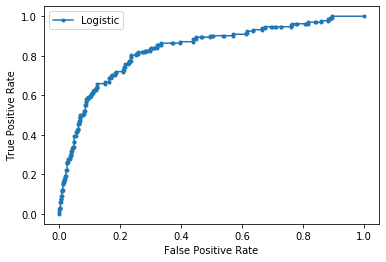

In [31]:
lr_probs = modelo_rl.predict_proba(Xts)
lr_probs = lr_probs[:, 1]

lr_fpr, lr_tpr, _ = roc_curve(yts, lr_probs)

plt.plot(lr_fpr,lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [36]:
ls_prob =  modelo_rl.predict_proba(X)

In [37]:
X['PROB_FALSE'] = ls_prob[:,0]
X['PROB_TRUE']  = ls_prob[:,1]

In [45]:
df_gn['CHURN_LR'] = X['CHURN_LR']   = [False if x>y else True for x,y in zip(ls_prob[:,0],ls_prob[:,1])]

In [56]:
df_gn['CHURN']

0       False
1       False
2       False
3       False
4       False
        ...  
3307    False
3308    False
3309    False
3310    False
3311    False
Name: CHURN, Length: 3312, dtype: bool

In [73]:
df_gn[df_gn['CHURN_LR']==False][[x.replace('W_','') for x in X.columns if x not in ['PROB_FALSE','PROB_TRUE']]].describe(percentiles=[0.99,0.01])

,NUM_EMAILMESSG,TOTAL_EVE_MINUTES,TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CHARGE,TOTAL_INTL_MINUTES,TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,NUM_EMAILMESSG/TOTAL_EVE_CALLS,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_CALLS/TOTAL_INTL_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS,TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS,TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS,TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS,ACCT_LENGTH/TOTAL_INTL_CALLS,NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS,NUM_EMAILMESSG/TOTAL_INTL_MINUTES
count,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000,3076.000000
mean,7.958062,201.603674,17.136528,201.086834,9.049002,10.297399,4.507152,2.780790,0.047015,0.083298,0.318781,0.016383,1.875151,3.129092,0.318558,0.046954,0.082708,0.016397,1.873840,30.205029,30.228871,60.749719,0.839404,60.853177,5.172581,30.262542,9.235545,2.733756,3.108434,30.267076,0.477729,54.325907,0.845062
std,13.569114,50.754707,4.314161,50.572369,2.275801,2.692504,2.447819,0.726932,0.028137,0.146526,0.124285,0.014577,0.731082,5.744461,0.120134,0.027834,0.146413,0.014745,0.706672,21.176811,20.721652,43.780998,0.607039,44.033674,3.742882,21.141550,6.932165,1.970155,2.248265,23.999474,0.576097,40.777491,1.551481
min,0.000000,31.200000,2.650000,23.200000,1.040000,1.300000,1.000000,0.350000,0.006536,0.000000,0.003894,0.000000,0.023009,0.000000,0.002821,0.006452,0.000000,0.000000,0.016667,4.000000,3.642857,3.750000,0.058333,3.120000,0.265000,4.105263,0.088000,0.169167,0.216667,0.111111,0.000000,0.520000,0.000000
1%,0.000000,79.825000,6.785000,79.000000,3.555000,3.975000,1.000000,1.072500,0.008677,0.000000,0.082269,0.000000,0.483745,0.000000,0.084519,0.008511,0.000000,0.000000,0.496978,7.097727,7.000000,11.848333,0.153214,11.891667,1.010625,7.087413,1.575167,0.533000,0.567460,2.339286,0.000000,9.266667,0.000000
50%,0.000000,202.400000,17.200000,201.950000,9.090000,10.300000,4.000000,2.780000,0.040984,0.000000,0.304907,0.012423,1.793519,0.000000,0.306215,0.040650,0.000000,0.012195,1.801388,24.400000,24.666667,48.816667,0.664000,48.787500,4.146250,24.600000,7.340000,2.196667,2.460000,24.000000,0.333333,43.173333,0.000000
99%,42.250000,318.850000,27.105000,315.425000,14.197500,16.700000,13.000000,4.510000,0.140890,0.522889,0.699157,0.066667,4.112740,21.977273,0.680977,0.141095,0.525160,0.063492,4.005941,115.250000,115.000000,240.550000,3.357500,241.225000,20.502500,117.500000,38.280000,10.827500,12.425000,127.000000,3.000000,225.200000,5.921826
max,51.000000,363.700000,30.910000,395.000000,17.770000,20.000000,20.000000,5.400000,0.250000,0.756757,1.228000,0.125000,7.223333,42.307692,1.126429,0.243590,0.857143,0.131579,6.626190,153.000000,149.000000,321.300000,4.910000,339.900000,28.890000,155.000000,55.470000,14.460000,18.200000,194.000000,6.000000,326.300000,11.379310


In [74]:
df_gn[df_gn['CHURN_LR']==True][[x.replace('W_','') for x in X.columns if x not in ['PROB_FALSE','PROB_TRUE']]].describe(percentiles=[0.99,0.01])

,NUM_EMAILMESSG,TOTAL_EVE_MINUTES,TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CHARGE,TOTAL_INTL_MINUTES,TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,NUM_EMAILMESSG/TOTAL_EVE_CALLS,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_CALLS/TOTAL_INTL_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS,TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS,TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS,TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS,ACCT_LENGTH/TOTAL_INTL_CALLS,NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS,NUM_EMAILMESSG/TOTAL_INTL_MINUTES
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,10.254237,194.442373,16.527754,197.514407,8.888051,10.255508,4.470339,2.769788,0.046092,0.104877,0.315663,0.015409,1.856798,3.976999,0.314955,0.046453,0.107056,0.015295,1.852628,30.496320,30.094072,59.978602,0.853108,59.242951,5.035677,29.782414,9.195667,2.699033,3.158672,30.806539,0.410623,54.090976,1.074429
std,15.276006,48.450650,4.118028,51.145353,2.301679,2.734541,2.423987,0.738391,0.027262,0.160738,0.123889,0.014856,0.728765,6.536398,0.127513,0.028615,0.163085,0.014096,0.750067,20.167547,19.630175,44.544517,0.654072,43.627314,3.708287,19.398351,6.719310,2.004551,2.421822,24.211251,0.439835,39.525080,1.767039
min,0.000000,52.900000,4.500000,65.800000,2.960000,1.100000,1.000000,0.300000,0.008197,0.000000,0.064480,0.000000,0.379200,0.000000,0.068889,0.008065,0.000000,0.000000,0.405185,6.222222,5.222222,7.822222,0.080714,10.580000,0.900000,4.166667,0.770556,0.352222,0.300000,3.750000,0.000000,4.533333,0.000000
1%,0.000000,90.400000,7.688000,92.545000,4.162000,3.125000,1.000000,0.843500,0.009234,0.000000,0.094872,0.000000,0.558008,0.000000,0.094579,0.009150,0.000000,0.000000,0.556334,6.907143,6.227778,13.047500,0.131378,13.151703,1.117956,6.698571,1.056500,0.587375,0.485556,4.434127,0.000000,6.213750,0.000000
50%,0.000000,191.350000,16.265000,193.550000,8.710000,10.500000,4.000000,2.840000,0.040202,0.000000,0.297252,0.011236,1.748541,0.000000,0.299874,0.040000,0.000000,0.011835,1.763945,24.875000,25.000000,46.354167,0.662333,47.401429,4.029429,25.000000,7.554500,2.085833,2.453333,23.291667,0.316667,44.440000,0.000000
99%,44.300000,321.075000,27.290000,331.510000,14.917500,16.330000,11.950000,4.409000,0.144792,0.521970,0.678904,0.062103,3.993459,24.193378,0.612330,0.149722,0.525520,0.060115,3.601645,108.300000,103.650000,242.755000,3.536000,245.070000,20.829500,109.300000,36.494000,10.925000,13.085000,124.950000,2.000000,214.675000,6.520609
max,50.000000,341.300000,29.010000,345.800000,15.560000,17.800000,18.000000,4.810000,0.160714,0.600000,0.811091,0.114754,4.770909,41.176471,1.224444,0.240000,0.592105,0.083333,7.202778,122.000000,122.000000,329.300000,4.050000,292.500000,24.860000,124.000000,40.940000,14.820000,15.000000,171.000000,3.000000,240.800000,11.200000


In [43]:
df_gn[df_gn['NUM_EMAILMESSG']<0]

,CHURN,PHONE_NUMBER,STATE,AREA_CODE,FLAG_INTL_PLAN,FLAG_VOICEMAIL_PLAN,ACCT_LENGTH,NUM_EMAILMESSG,TOTAL_DAY_MINUTES,TOTAL_DAY_CALLS,TOTAL_DAY_CHARGE,TOTAL_EVE_MINUTES,TOTAL_EVE_CALLS,TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CALLS,TOTAL_NIGHT_CHARGE,TOTAL_INTL_MINUTES,TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE,NUM_CUSTSERV_CALLS,TOTAL_DAY_CALLS/TOTAL_EVE_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_EVE_CALLS,TOTAL_INTL_CHARGE/TOTAL_EVE_CALLS,TOTAL_EVE_MINUTES/TOTAL_EVE_CALLS,TOTAL_EVE_CHARGE/TOTAL_EVE_CALLS,TOTAL_NIGHT_CALLS/TOTAL_EVE_CALLS,TOTAL_DAY_CHARGE/TOTAL_EVE_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_EVE_CALLS,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,TOTAL_INTL_MINUTES/TOTAL_EVE_CALLS,NUM_EMAILMESSG/TOTAL_EVE_CALLS,ACCT_LENGTH/TOTAL_EVE_CALLS,NUM_CUSTSERV_CALLS/TOTAL_EVE_CALLS,TOTAL_DAY_MINUTES/TOTAL_EVE_CALLS,TOTAL_EVE_CALLS/TOTAL_DAY_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_DAY_CALLS,TOTAL_INTL_CHARGE/TOTAL_DAY_CALLS,TOTAL_EVE_MINUTES/TOTAL_DAY_CALLS,TOTAL_EVE_CHARGE/TOTAL_DAY_CALLS,TOTAL_NIGHT_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_DAY_CALLS,TOTAL_INTL_CALLS/TOTAL_DAY_CALLS,TOTAL_INTL_MINUTES/TOTAL_DAY_CALLS,NUM_EMAILMESSG/TOTAL_DAY_CALLS,ACCT_LENGTH/TOTAL_DAY_CALLS,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,TOTAL_EVE_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_DAY_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_INTL_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_EVE_MINUTES/TOTAL_NIGHT_MINUTES,TOTAL_EVE_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_DAY_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_MINUTES,TOTAL_INTL_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_INTL_MINUTES/TOTAL_NIGHT_MINUTES,NUM_EMAILMESSG/TOTAL_NIGHT_MINUTES,ACCT_LENGTH/TOTAL_NIGHT_MINUTES,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_MINUTES,TOTAL_DAY_MINUTES/TOTAL_NIGHT_MINUTES,TOTAL_EVE_CALLS/TOTAL_INTL_CHARGE,TOTAL_DAY_CALLS/TOTAL_INTL_CHARGE,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CHARGE,TOTAL_EVE_MINUTES/TOTAL_INTL_CHARGE,TOTAL_EVE_CHARGE/TOTAL_INTL_CHARGE,TOTAL_NIGHT_CALLS/TOTAL_INTL_CHARGE,TOTAL_DAY_CHARGE/TOTAL_INTL_CHARGE,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CHARGE,TOTAL_INTL_CALLS/TOTAL_INTL_CHARGE,TOTAL_INTL_MINUTES/TOTAL_INTL_CHARGE,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,ACCT_LENGTH/TOTAL_INTL_CHARGE,NUM_CUSTSERV_CALLS/TOTAL_INTL_CHARGE,TOTAL_DAY_MINUTES/TOTAL_INTL_CHARGE,TOTAL_EVE_CALLS/TOTAL_EVE_MINUTES,TOTAL_DAY_CALLS/TOTAL_EVE_MINUTES,TOTAL_NIGHT_MINUTES/TOTAL_EVE_MINUTES,TOTAL_INTL_CHARGE/TOTAL_EVE_MINUTES,TOTAL_EVE_CHARGE/TOTAL_EVE_MINUTES,TOTAL_NIGHT_CALLS/TOTAL_EVE_MINUTES,TOTAL_DAY_CHARGE/TOTAL_EVE_MINUTES,TOTAL_NIGHT_CHARGE/TOTAL_EVE_MINUTES,TOTAL_INTL_CALLS/TOTAL_EVE_MINUTES,TOTAL_INTL_MINUTES/TOTAL_EVE_MINUTES,NUM_EMAILMESSG/TOTAL_EVE_MINUTES,ACCT_LENGTH/TOTAL_EVE_MINUTES,NUM_CUSTSERV_CALLS/TOTAL_EVE_MINUTES,TOTAL_DAY_MINUTES/TOTAL_EVE_MINUTES,TOTAL_EVE_CALLS/TOTAL_EVE_CHARGE,TOTAL_DAY_CALLS/TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES/TOTAL_EVE_CHARGE,TOTAL_INTL_CHARGE/TOTAL_EVE_CHARGE,TOTAL_EVE_MINUTES/TOTAL_EVE_CHARGE,TOTAL_NIGHT_CALLS/TOTAL_EVE_CHARGE,TOTAL_DAY_CHARGE/TOTAL_EVE_CHARGE,TOTAL_NIGHT_CHARGE/TOTAL_EVE_CHARGE,TOTAL_INTL_CALLS/TOTAL_EVE_CHARGE,TOTAL_INTL_MINUTES/TOTAL_EVE_CHARGE,NUM_EMAILMESSG/TOTAL_EVE_CHARGE,ACCT_LENGTH/TOTAL_EVE_CHARGE,NUM_CUSTSERV_CALLS/TOTAL_EVE_CHARGE,TOTAL_DAY_MINUTES/TOTAL_EVE_CHARGE,TOTAL_EVE_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_CALLS/TOTAL_NIGHT_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_INTL_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_EVE_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_NIGHT_CALLS,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,TOTAL_INTL_MINUTES/TOTAL_NIGHT_CALLS,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,ACCT_LENGTH/TOTAL_NIGHT_CALLS,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS,TOTAL_EVE_CALLS/TOTAL_DAY_CHARGE,TOTAL_DAY_CALLS/TOTAL_DAY_CHARGE,TOTAL_NIGHT_MINUTES/TOTAL_DAY_CHARGE,TOTAL_INTL_CHARGE/TOTAL_DAY_CHARGE,TOTAL_EVE_MINUTES/TOTAL_DAY_CHARGE,TOTAL_EVE_CHARGE/TOTAL_DAY_CHARGE,TOTAL_NIGHT_CALLS/TOTAL_DAY_CHARGE,TOTAL_NIGHT_CHAR

In [23]:
df_gn[[x for x in df_woe.columns if x!='CHURN']].shape

(3312, 36)

In [24]:
df_woe_aux[[x.replace('W_','') for x in df_woe_aux.columns if x in ls_c_w and x!='CHURN']].sample()

,STATE,FLAG_INTL_PLAN,FLAG_VOICEMAIL_PLAN,NUM_EMAILMESSG,TOTAL_EVE_MINUTES,TOTAL_EVE_CHARGE,TOTAL_NIGHT_MINUTES,TOTAL_NIGHT_CHARGE,TOTAL_INTL_MINUTES,TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE,NUM_EMAILMESSG/TOTAL_INTL_MINUTES,TOTAL_INTL_MINUTES/TOTAL_INTL_CALLS,TOTAL_DAY_CHARGE/TOTAL_INTL_CALLS,TOTAL_EVE_MINUTES/TOTAL_INTL_CALLS,TOTAL_EVE_CHARGE/TOTAL_INTL_CALLS,TOTAL_NIGHT_MINUTES/TOTAL_INTL_CALLS,TOTAL_DAY_CALLS/TOTAL_INTL_CALLS,ACCT_LENGTH/TOTAL_INTL_CALLS,NUM_CUSTSERV_CALLS/TOTAL_INTL_CALLS,TOTAL_INTL_CHARGE/TOTAL_INTL_CALLS,TOTAL_EVE_CALLS/TOTAL_INTL_CALLS,TOTAL_NIGHT_CALLS/TOTAL_INTL_CALLS,TOTAL_DAY_MINUTES/TOTAL_INTL_CALLS,TOTAL_NIGHT_CHARGE/TOTAL_INTL_CALLS,TOTAL_DAY_CHARGE/TOTAL_DAY_CALLS,NUM_CUSTSERV_CALLS/TOTAL_DAY_CALLS,TOTAL_DAY_MINUTES/TOTAL_DAY_CALLS,NUM_EMAILMESSG/TOTAL_INTL_CHARGE,NUM_EMAILMESSG/TOTAL_EVE_CALLS,TOTAL_INTL_CALLS/TOTAL_EVE_CALLS,TOTAL_DAY_CHARGE/TOTAL_NIGHT_CALLS,NUM_EMAILMESSG/TOTAL_NIGHT_CALLS,TOTAL_INTL_CALLS/TOTAL_NIGHT_CALLS,NUM_CUSTSERV_CALLS/TOTAL_NIGHT_CALLS,TOTAL_DAY_MINUTES/TOTAL_NIGHT_CALLS
6,DC,no,yes,"(-0.597, 0.338]","(0.585, 1.899]","(0.584, 1.898]","(0.163, 2.0]","(0.161, 1.998]","(-1.074, 1.264]","(-1.442, 0.121]","(-1.072, 1.265]","(-0.557, 0.902]","(2.697, 4.686]","(3.483, 5.085]","(4.814, 6.346]","(4.814, 6.345]","(4.272, 6.129]","(3.407, 5.755]","(3.588, 5.203]","(-0.845, 1.281]","(2.693, 4.681]","(1.582, 2.994]","(2.347, 4.142]","(3.483, 5.085]","(4.273, 6.13]","(-2.544, 0.752]","(-1.1269999999999998, 1.023]","(-2.544, 0.752]","(-0.558, 0.908]","(-0.581, 0.451]","(-1.4489999999999998, 0.295]","(0.76, 4.136]","(-0.578, 0.589]","(-1.4609999999999999, 0.675]","(-1.1199999999999999, 1.128]","(0.761, 4.136]"


In [25]:
df_woe_aux_df = df_woe_aux[[x.replace('W_','') for x in df_woe_aux.columns if x in ls_c_w and x!='CHURN']]

In [26]:
ls_pr_modelo = modelo_rl.predict_proba(df_woe[[x for x in df_woe.columns if x!='CHURN']])

df_gn['LR_F'] = ls_pr_modelo[:,1]
df_gn['LR_T'] = ls_pr_modelo[:,0]

df_gn['CHURN_LR'] = [False if x>y else True for x,y in zip(df_gn['LR_T'],df_gn['LR_F'])]

df_gn['CHURN_LR'].value_counts()

False    3070
True      242
Name: CHURN_LR, dtype: int64

STATE


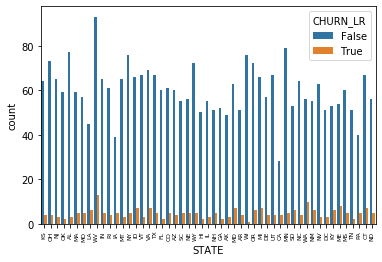

In [27]:
count_plot('STATE',df_gn,flag='CHURN_LR')

FLAG_INTL_PLAN


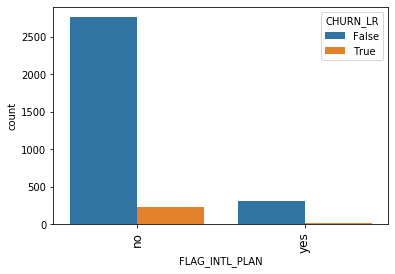

In [28]:
count_plot('FLAG_INTL_PLAN',df_gn,flag='CHURN_LR')

In [29]:
df_woe_aux_df = df_woe_aux_df.rename(columns=dict(zip(df_woe_aux_df.columns,['W_'+x for x in df_woe_aux_df.columns])))
df_woe_aux_df = df_woe_aux_df.rename(columns=dict(zip([x for x in df_woe_aux_df.columns],[x.replace('W_','D_') for x in df_woe_aux_df.columns])))

### Naive Bayes

In [69]:
#Train and test datasets
Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=0.7)

model_nb    = GaussianNB()

model_nb.fit(Xtr,ytr)
print('ROC')
print (roc_auc_score(y_true=ytr,y_score=model_nb.predict_proba(Xtr)[:,1]))
print (roc_auc_score(y_true=yts,y_score=model_nb.predict_proba(Xts)[:,1]))
print('Accuracy')
print (accuracy_score(y_true=yts,y_pred=model_nb.predict(Xts)))
print (accuracy_score(y_true=ytr,y_pred=model_nb.predict(Xtr)))

ROC
0.8008113320378925
0.8214030095287371
Accuracy
0.8108651911468813
0.7864538395168249


/home/jeniffer/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


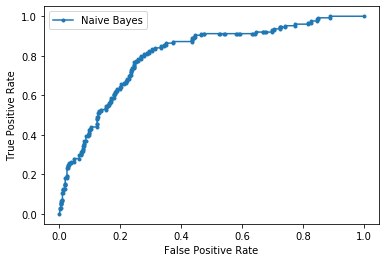

In [39]:
lr_probs = model_nb.predict_proba(Xts)
lr_probs = lr_probs[:, 1]

lr_fpr, lr_tpr, _ = roc_curve(yts, lr_probs)

plt.plot(lr_fpr,lr_tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### K VECINOS

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
#Train and test datasets
Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=0.7)

model_kn    = KNeighborsClassifier(n_neighbors=15)

model_kn.fit(Xtr,ytr)
print('ROC')
print (roc_auc_score(y_true=ytr,y_score=model_kn.predict_proba(Xtr)[:,1]))
print (roc_auc_score(y_true=yts,y_score=model_kn.predict_proba(Xts)[:,1]))
print('Accuracy')
print (accuracy_score(y_true=yts,y_pred=model_kn.predict(Xts)))
print (accuracy_score(y_true=ytr,y_pred=model_kn.predict(Xtr)))

/home/jeniffer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


ROC
0.9163769653765432
0.8391137049225285
Accuracy
0.89738430583501
0.9020707506471096


In [ ]:
df_gn['CHURN_LR'] = X['CHURN_LR']   = [False if x>y else True for x,y in zip(ls_prob[:,0],ls_prob[:,1])]

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_da = LinearDiscriminantAnalysis()
model_da.fit(X, y)
model_da.fit(Xtr,ytr)
print('ROC')
print (roc_auc_score(y_true=ytr,y_score=model_da.predict_proba(Xtr)[:,1]))
print (roc_auc_score(y_true=yts,y_score=model_da.predict_proba(Xts)[:,1]))
print('Accuracy')
print (accuracy_score(y_true=yts,y_pred=model_da.predict(Xts)))
print (accuracy_score(y_true=ytr,y_pred=model_da.predict(Xtr)))

ROC
0.8521665675018548
0.8392116447631783
Accuracy
0.8621730382293763
0.868421052631579


/home/jeniffer/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jeniffer/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_gn['CHURN_LR'] = X['CHURN_LR']   = [False if x>y else True for x,y in zip(ls_prob[:,0],ls_prob[:,1])]